<a href="https://colab.research.google.com/github/ion-bueno/distilbert-from-inside/blob/main/inside_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The aim of this notebook is to compare **BERT** and **DistilBERT** models in the resolution of two classical NLP tasks, classification with **multiple classes** and with **multiple labels**. Mention these models are more used in language modeling as question answering, but due to the available computational power, only simple tasks can be implemented.

As it is known, BERT meant a significant improvement in the area, but the computational cost is not affordable in some cases and it is a critical point to consider. For this reason, DistilBERT arises as a solution for these massive models, where it reaches the same performance with half the resources.

This notebook is part of my master thesis, where you can find more details and mathematical explanations of DistilBERT and its novel mechanisms. The memory as well as the results are published in my GitHub: [ion-bueno/distilbert-from-inside](https://github.com/ion-bueno/distilbert-from-inside). Also mention that this work is the continuation of my bachelor thesis, which was only focused on BERT, so more details about the implementation can be found in the notebook published in [ion-bueno/bert-from-inside](https://github.com/ion-bueno/bert-from-inside).

# Setup

Before going into detail with the development, it is required to install some packages and define some functions as well as variables.

## Package installation

It is employed the [Hugging Face](https://huggingface.co/) models of [BERT](https://huggingface.co/docs/transformers/model_doc/bert) and [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) developed in **PyTorch**, so it is required to install the `transformers` package. The other two are also employed along the work.

In [ ]:
!pip3 install transformers
!pip install wget
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 596 kB 51.1 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a6189ba2c71ea0291b47e3e48554abba155dd50746e1c6735214cabebb27440b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Modules

All modules employed are loaded in next cell. It is used packages from PyTorch, sklearn, Hugging Face, Colab, etc.

In [ ]:
# Standard modules
import os
from pathlib import Path
import shutil
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import json
import random
import time
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')
# Pytorch modules
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
# Transformers
from transformers import BertTokenizerFast, BertModel, DistilBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
# Sklearn
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
# Colab modules
from google.colab import files

## Global variables

In both cases the **uncased** version is employed, what means that no difference is considered between lower and upper letters. It eases the computation. These two variables are used in the Hugging Face's APIs to call the pretrained models.

In [ ]:
BERT_NAME = 'bert-base-uncased'
DISTILBERT_NAME = 'distilbert-base-uncased'

In addition, the **seed** is fixed in order to have reproducible results.

> Mention that executing the notebook in different operating systems may lead to other results. This one has been executed in **Kubuntu 20.04**.

In [ ]:
seed = 100364530
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

## Recurrent functions

As these functions are used repeatedly along the notebook, they are defined at first instance in order to be cleaner and clearer afterwards. The first two correspond with selecting the runtime type (CPU or GPU) and printing the information.

In [ ]:
def set_up_runtime():
    '''Set GPU if available
    
    '''
    # If there's a GPU available...
    if torch.cuda.is_available():    
        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device


def info_device(device):
    '''Print if we are using the GPU

    '''
    # If there's a GPU available
    if device.type == 'cuda':
        print(f'\nUsing GPU {torch.cuda.get_device_name(0)}', '\n')
    # If not
    else:
        print('\nNo GPU available, using the CPU instead', '\n')

These functions are used to resize the data as well as obtaining the corresponding splits: training, test and validation.

In [ ]:
def resize_dataset(dataset, perc):
    '''Resize dataset according to a percentage

    '''
    re_dataset = dataset.sample(frac=perc/100, random_state=seed)
    if perc != 100:
        print(f'From: {len(dataset):<10}', f'To: {len(re_dataset):<10}')
    else:
        print(f'Samples: {len(dataset):<10}')
    return re_dataset


def data_splitting(dataset, train_perc, val_perc):
    '''Splitting dataset in training, test and validation
    
    '''
    datasets = {'train': None, 'val': None, 'test': None}

    # Train-test
    datasets['train'] = dataset.sample(frac=train_perc/100, random_state=seed)
    datasets['test'] = dataset.drop(datasets['train'].index).reset_index(drop=True)
    datasets['train'] = datasets['train'].reset_index(drop=True)

    # Val-test
    datasets['val'] = datasets['train'].sample(frac=val_perc/100, random_state=seed)
    datasets['train'] = datasets['train'].drop(datasets['val'].index).reset_index(drop=True)
    datasets['val'] = datasets['val'].reset_index(drop=True)

    print(58*'-')
    print(f"| {'Total samples':^15} | {'Training':^10} | {'Validation':^10} | {'Test':^10} |")
    print(58*'-')
    print(f"| {len(dataset):^15} | {len(datasets['train']):^10} | {len(datasets['val']):^10} | {len(datasets['test']):^10} |")
    print(58*'-')
    
    return datasets

Save used data, tokenizer, hyperparameters, models and results, as well as downloading the folders.

In [ ]:
def save_used_data(path, datasets):
    '''Save employed data

    '''
    # Data directory
    data_dir = path/'data'
    if not os.path.exists(data_dir):
        !mkdir $data_dir
    for sp, df in datasets.items():
        name_df = sp + '.csv'
        data_path = data_dir/name_df
        if os.path.exists(data_path):
            os.remove(data_path)
        df.to_csv(data_path)
        print(f'Dataset {name_df} saved in {data_path}')


def save_tokenizer(path, tokenizer):
    '''Save tokenizer

    '''
    # Tokenizer directory
    tokenizer_dir = path/'tokenizer'
    if not os.path.exists(tokenizer_dir):
        !mkdir $tokenizer_dir
    tokenizer.save_pretrained(tokenizer_dir)
    print(f'Tokenizer saved in {tokenizer_dir}')


def save_json(path, file):
    '''Save a dictionary in json format

    '''
    with open(path, "w") as outfile:
        json.dump(file, outfile)


def get_hyperparameters(batch_sizes, classifier_params, training_params):
    '''Obtain hyperparameters of a model

    '''
    params = {
        'batch_sizes': batch_sizes,
        'classifier': classifier_params,
        'training': training_params
    }
    return params


def save_hyperparameters(path, hyperparams):
    '''Save hyperparameters of a model

    '''
    name_dic = 'hyperparameters.json'
    data_path = path/name_dic
    save_json(data_path, hyperparams)
    print(f'Hyperparameters saved in {data_path}')


def save_model(path, model, epoch=None):
    '''Save a model per epoch

    '''
    # Model directory
    model_name = model.name.lower()
    model_dir = path/model_name
    if not os.path.exists(model_dir):
        !mkdir $model_dir
    if epoch:
        saved_model = 'model-ep' + str(epoch) + '.pth'
    else:
        saved_model = 'model.pth'
    model_path = model_dir/saved_model
    torch.save(model.state_dict(), model_path)
    print(f'{model.name} model saved in {model_path}')


def save_statistics(path, name, df=None, dic=None):
    '''Save results

    '''
    if df is not None:
        df_name = name + '.xlsx'
        df_path = path/df_name
        df.to_excel(df_path)
        print(f'Statistics saved in {df_path}')

    if dic:
        dic_name = name + '.json'
        dic_path = path/dic_name
        save_json(dic_path, dic)
        print(f'JSON file saved in {dic_path}')


def download_folder(dir): 
    '''Download a folder

    '''
    !zip -r $dir\.zip $dir
    files.download(f'{dir}.zip')

Show information about the models.

In [ ]:
def show_model(model, block):
    '''Print architecture of the specified model

    '''
    if model=='BERT':
        mod = bert
    else:
        mod = distilbert
    if block == 'all':
        print(mod)
    else:
        print(getattr(mod, block))


def show_params(model, show_layers=False):
    '''Show the total number of parameters (and per layer) of a model

    '''
    if model=='BERT':
        mod = bert
    else:
        mod = distilbert
    n = sum(param.numel() for param in mod.parameters())
    print(f'Total number of parameters = {n}')
    if show_layers:
        print('\n\nSize per block and layer\n')
        for name, module in mod.named_modules():
            if not name:
                continue
            print(name, sum(param.numel() for param in module.parameters()))


def print_model_name(model):
    '''Print the name of the model
    
    '''
    name = model.name
    print((len(name)+4)*'-')
    print(f'| {name} |')
    print((len(name)+4)*'-', '\n')

These functions are employed during the training or evaluation process of the models.

In [ ]:
def format_time(elapsed):
    '''Takes a time in seconds and returns a string hh:mm:ss

    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def load_best_model(dir, trainer, epoch):
    '''Select best trained model given an epoch

    '''
    best_model = 'model-ep' + str(epoch) + '.pth'
    trainer.model.load_state_dict(torch.load(dir/best_model))
    trainer.model.to(trainer.device)


def plot_loss_curves(df):
    '''Plot training and validation loss curves

    '''
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df['train_loss'], 'b-o', label="training")
    plt.plot(df['val_loss'], 'g-o', label="validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 2 decimal places
    plt.xticks(df.index.values)
    plt.show()


def plot_accuracy(df):
    '''Plot validation accuracy

    '''
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df['accuracy'], 'g-o')

    # Label the plot.
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 2 decimal places
    plt.xticks(df.index.values)
    plt.show()


def plot_hamming(df):
    '''Plot validation hamming score

    '''
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df['hamming'], 'g-o')

    # Label the plot.
    plt.title("Validation Hamming Score")
    plt.xlabel("Epoch")
    plt.ylabel("Hamming Score")
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 2 decimal places
    plt.xticks(df.index.values)
    plt.show()


def plot_confusion_matrix(cm, classes, normalize=True):
    '''Plot confusion matrix

    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{title}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + ((cm.max() - cm.min()) / 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def evaluate_roc(probs, y_true, plot=True):
    '''Evaluate and plot roc curve

    '''
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    
    if plot:
        # title
        plt.title(f'Receiver Operating Characteristic\nAUC = {roc_auc:.2f}, Best G-Mean = {gmeans[ix]:.2f}')
        # plot ROC curve
        plt.plot([0, 1], [0, 1],'--', label='No skill')
        plt.plot(fpr, tpr, marker='.', label='Bert Classifier')
        plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold = {thresholds[ix]:.2f}')
        # show legend
        plt.legend(loc = 'lower right')
        # axis labels
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        # show plot
        plt.show()
    return thresholds[ix]

## Pre-processing class

In both models and both tasks the data preprocessing is almost the same, for this reason, one class is employed to carry out the work. The steps are the following, although they will be explained after with more detail:

* Calculate the maximum lenght in the whole data.
* Encode the data.
* Store the data in dataloaders.

In [ ]:
class Processing():
    def __init__(self, datasets):
        self.datasets = datasets
        self.tokenizer = None
        self.max_len = 512
        self.encoded_datasets = {}
        self.dataloaders = {}


    def get_max_len(self):
        '''Obtain maximum length of all sentences, after encoding

        '''
        print('Calculating largest length...')
        # Concatenate sentences in datasets
        all_sentences = np.concatenate([
            self.datasets['train'].text.values, 
            self.datasets['val'].text.values, 
            self.datasets['test'].text.values
        ])

        # Encode our concatenated data
        encoded_sentences = [self.tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]

        # Find the maximum length
        max_len = max([len(sent) for sent in encoded_sentences])
        self.max_len = max_len
        print(f'The largest length is {self.max_len}')


    def encode(self, data):
        '''Encode sentences of a dataset

        '''
        # Create empty lists to store outputs
        input_ids = []
        attention_masks = []
        for text in data:
            text = str(text)
            text = " ".join(text.split())
            encoded_sent = self.tokenizer.encode_plus(
                text,                             # Tokenize sentence
                add_special_tokens=True,          # Add `[CLS]` and `[SEP]`
                max_length=self.max_len,          # Max length to truncate/pad
                pad_to_max_length=True,           # Pad sentence to max length
                truncation=True,                  # Truncate to max_length
                return_attention_mask=True,       # Return attention mask
                return_token_type_ids=True        # Return token type ids
            )
            # Get output and attention mask
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        # Convert lists to tensors
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_masks = torch.tensor(attention_masks, dtype=torch.long)

        return input_ids, attention_masks

    def encode_datasets(self, long_labels=True):
        '''Encode training, validation and test split

        '''
        for sp, df in self.datasets.items():
            print(f'Processing {sp} dataset...') 
            self.encoded_datasets[sp] = dict()
            # Get input_ids and attention mask
            self.encoded_datasets[sp]['input_ids'], self.encoded_datasets[sp]['attention_mask'] = self.encode(df.text)
            # Add the corresponding labels
            if long_labels:
                type_labels = torch.long
            else:
                type_labels = torch.float
            self.encoded_datasets[sp]['labels'] = torch.tensor(df.labels, dtype=type_labels)


    def get_dataloaders(self, batch_sizes):
        '''Obtain a dataloader per split
        
        '''
        for sp, dataset in self.datasets.items():
            print(f'Generating {sp} dataloader...')
            data = TensorDataset(
                self.encoded_datasets[sp]['input_ids'], 
                self.encoded_datasets[sp]['attention_mask'], 
                self.encoded_datasets[sp]['labels']
            )
            if sp == 'test':
                sampler = SequentialSampler(data)
            else:
                sampler = RandomSampler(data)
            self.dataloaders[sp] = DataLoader(
                data, 
                sampler=sampler, 
                batch_size=batch_sizes[sp]
            )

# 1 - Multiclass classification

One of the most common problems in NLP, where a given piece of text or sentence needs to be classified in one category of a given list. Each sample corresponds with only one class. It is used the [News aggregator dataset](https://archive.ics.uci.edu/ml/datasets/News+Aggregator) by UCI Machine Learning Repository, composed by news headline which can be grouped into 4 categories:

* Business.
* Science.
* Entertainment.
* Health.

## 1.1 - Setup

In spite of being much faster than pre-training, fine-tune a BERT model for any class could be slow for a CPU. Due to that, it is recommended to use a GPU.

> In case of running it from Colab, Google's GPUs can be used. Make sure to select GPU from *Runtime > Change runtime type > Hardware accelerator > GPU*.

In [ ]:
device = set_up_runtime()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


The same device is used for both models in order to compare the spent time.

## 1.2 - Load data

Firstly, the data is downloaded making use of the URL. All the data as well as the models are going to be stored in a folder called **multiclass**.

In [ ]:
# Dataset directory
multiclass_dir = Path('multiclass')
if not os.path.exists(multiclass_dir):
    !mkdir $multiclass_dir

# The URL for the dataset zip file.
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip'

# Download the file (if we haven't already)
if not os.path.exists('./NewsAggregatorDataset.zip'):
    print('Downloading dataset...')
    wget.download(url, './NewsAggregatorDataset.zip')

# Unzip the dataset (if we haven't already)
data_path = multiclass_dir/'newsCorpora.csv'
if not os.path.exists(data_path):
    !unzip NewsAggregatorDataset.zip
    shutil.move('newsCorpora.csv', data_path)
    os.remove('2pageSessions.csv')
    os.remove('readme.txt')
    os.remove('NewsAggregatorDataset.zip')
    shutil.rmtree('__MACOSX')

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


The original data have several columns which do not provide any useful information, only the sentence to classify and the corresponding category are necessary.

In [ ]:
original_dataset = pd.read_csv(data_path, sep='\t', names=['id','title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])
os.remove(data_path)
pd.set_option("max_colwidth", 150)
original_dataset.head()

,id,title,url,publisher,category,story,hostname,timestamp
0,1,"Fed official says weak data caused by weather, should not slow taper","http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss",Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change in pace of tapering,http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints at accelerated tapering,http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles Plosser says",http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Growth,http://www.moneynews.com/Economy/federal-reserve-charles-plosser-weather-job-growth/2014/03/10/id/557011,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


### 1.2.1 - Cleaning data

Several steps are carried out to obtain the data in an useful format:

* Extract only the columns corresponding to title and category.
* Remove titles larger than 512 words (maximum length allowed by BERT and DistilBERT).
* Convert the categories (encoded as letters) to labels, from 0 to 3.
* Rename columns: useful for preprocessing with the `Processing` class.

In [ ]:
# Removing unwanted columns and only leaving title of news and the category which will be the target
dataset = original_dataset[['title','category']]

# Remove bad titles, longer than 512
dataset = dataset[dataset.title.str.len() <512].reset_index(drop=True)

# Converting the codes to appropriate categories using a dictionary
my_dic = {
    'e':'entertainment',
    'b':'business',
    't':'science',
    'm':'health'
}

def update_cat(x):
    return my_dic[x]

dataset['category'] = dataset['category'].apply(lambda x: update_cat(x))

category_dic = {}

def encode_cat(x):
    if x not in category_dic.keys():
        category_dic[x] = len(category_dic)
    return category_dic[x]

dataset['labels'] = dataset['category'].apply(lambda x: encode_cat(x))
dataset = dataset.rename(columns={'title': 'text'})

The labels and their corresponding categories are stored in the dictionary `label_dic`.

In [ ]:
label_dic = {v: k for k, v in category_dic.items()}
label_dic

{0: 'business', 1: 'science', 2: 'entertainment', 3: 'health'}

Finally this is the used dataset, in which each sample is composed by text and a label.

In [ ]:
dataset.sample(5)

,text,category,labels
287347,'Field of Dreams' Anniversary Dream Come True for Fans,entertainment,2
48817,Facebook CEO sees telemedicine opportunity with $2B Oculus acquisition,science,1
263999,Google unveils self-driving cars that don't need steering wheels or brake pedals,science,1
292251,Coleman: Casey Kasem: Pop's 'gateway drug',entertainment,2
167632,Homeland Security warns against using Internet Explorer until Microsoft fixes ...,science,1


### 1.2.2 - Resize dataset

Depending on the computation velocity, training process could be very slow, so it can be removed some data for a fast intuition on the model. With `perc` it is selected the percentage of data to use. Removed sample are selected randomly.

In [ ]:
#@title { vertical-output: true }
#@markdown Percentage of dataset to use %
perc = 100 #@param {type:"slider", min:1, max:100, step:1}
re_dataset = resize_dataset(dataset, perc)

Samples: 422410    


### 1.2.3 - Data splitting

The data is splitted in three sets: training, validation and test. The percentages can be selected in next cell.

In [ ]:
#@title { vertical-output: true }
#@markdown Respect the total data:
train_perc = 80 #@param {type:"slider", min:1, max:100, step:1}
#@markdown Respect the training data:
val_perc = 10 #@param {type:"slider", min:1, max:100, step:1}
datasets = data_splitting(re_dataset, train_perc, val_perc)

----------------------------------------------------------
|  Total samples  |  Training  | Validation |    Test    |
----------------------------------------------------------
|     422410      |   304135   |   33793    |   84482    |
----------------------------------------------------------


It is important to know how many samples there are per class in the training set, in case an imbalanced classification problem is presented. The number of samples is going to depend on how the original dataset has been splitted.

In [ ]:
train_categories = datasets['train'].category
val_categories = datasets['val'].category
test_categories = datasets['test'].category

print(104*'-')
print(f"| {'Split':^10} | {'Total samples':^15} | {label_dic[0]:^15} | {label_dic[1]:^15} | {label_dic[2]:^15} | {label_dic[3]:^15} |")
print(104*'-')
print(f"| {'training':^10} | {len(datasets['train']):^15} | {len(datasets['train'][train_categories==label_dic[0]]):^15} | {len(datasets['train'][train_categories==label_dic[1]]):^15} | {len(datasets['train'][train_categories==label_dic[2]]):^15} | {len(datasets['train'][train_categories==label_dic[3]]):^15} |")
print(104*'-')
print(f"| {'validation':^10} | {len(datasets['val']):^15} | {len(datasets['val'][val_categories==label_dic[0]]):^15} | {len(datasets['val'][val_categories==label_dic[1]]):^15} | {len(datasets['val'][val_categories==label_dic[2]]):^15} | {len(datasets['val'][val_categories==label_dic[3]]):^15} |")
print(104*'-')
print(f"| {'test':^10} | {len(datasets['test']):^15} | {len(datasets['test'][test_categories==label_dic[0]]):^15} | {len(datasets['test'][test_categories==label_dic[1]]):^15} | {len(datasets['test'][test_categories==label_dic[2]]):^15} | {len(datasets['test'][test_categories==label_dic[3]]):^15} |")
print(104*'-')

--------------------------------------------------------------------------------------------------------
|   Split    |  Total samples  |    business     |     science     |  entertainment  |     health      |
--------------------------------------------------------------------------------------------------------
|  training  |     304135      |      83462      |      77918      |     110014      |      32741      |
--------------------------------------------------------------------------------------------------------
| validation |      33793      |      9443       |      8674       |      11982      |      3694       |
--------------------------------------------------------------------------------------------------------
|    test    |      84482      |      23062      |      21750      |      30466      |      9204       |
--------------------------------------------------------------------------------------------------------


In spite of having some differences between classes, the problem is not extremely imbalanced and it is not required any other preprocessing step to manage it. The three sets (training, validation and test) used to train the models are stored in the corresponding folder.

In [ ]:
save_used_data(multiclass_dir, datasets)

Dataset train.csv saved in multiclass/data/train.csv
Dataset val.csv saved in multiclass/data/val.csv
Dataset test.csv saved in multiclass/data/test.csv


## 1.3 - Pre-processing data

Before input sequences into BERT, it is necessary to preprocess data samples. The steps to perform depend on the model, but mainly the guide to follow is:

*   Tokenize sequences, converting text into integers according to embedding space used.
*   Pad each sentence to the maximum length which is in your batch.
*   Truncate each sentence to the maximum length the model can accept (if applicable). 


BERT and DistilBERT employ [WordPiece](https://research.google/pubs/pub37842/) subword tokenization algorithm. Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords. WordPiece is very similar to [Byte Pair Encoding (BPE)](https://arxiv.org/abs/1508.07909). Every character present in training data is included to learn the corresponding merge rules. In contrast to BPE that chooses the most frequent symbol pair, this algorithm maximizes the likelihood of the training data when it is added to the vocabulary. This approach evaluates if it is worthy to merge two symbols, instead of separated.

The input in both models follow next scheme for classification:


\begin{matrix}
    \text{[CLS]} & \text{Sentence} & \text{[SEP]}
\end{matrix} \\

First step is defining an object of the defined class `Processing` which is in charge of this work.

In [ ]:
processing = Processing(datasets)

In order to preprocess according to the model, it is going to be used the [`BertTokenizerFast`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertTokenizerFast) from Hugging Face, which ensures geting a tokenizer that corresponds to the desired model architecture. Besides that, it downloads the vocabulary used when pretraining this specific checkpoint. It is necessary to pass to the tokenizer the name of the pre-trained model it is going to be used, corresponding with the variable `BERT_NAME`. Mention that same tokenizer can be used in the case of DistilBERT, and it is implemented in that way to save repetitive code.

The tokenizer is saved as an attribute of the `processing` object.

In [ ]:
print('Loading tokenizer...')
processing.tokenizer = BertTokenizerFast.from_pretrained(BERT_NAME)

Loading tokenizer...


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

From tokenizer's instance it can be obtained information about the model:

- Dimension of the vocabulary used
- Maximum allowed length of the model
- In which size is applied padding
- Special used tokens for separation token, padding token, classification token, mask token and other unknown tokens.


In [ ]:
#@markdown Select an option to visualize it
attribute = "unk_token" #@param ["vocab_size", "model_max_length", "padding_side", "sep_token", "pad_token", "cls_token", "mask_token", "unk_token"]

print(41*'-')
print(f"| {'Attribute':^20}| {'Value':^15} |")
print(41*'-')
print(f"| {attribute:^20}| {getattr(processing.tokenizer, attribute):^15} |")
print(41*'-')

-----------------------------------------
|      Attribute      |      Value      |
-----------------------------------------
|      unk_token      |      [UNK]      |
-----------------------------------------


BERT and DistilBERT work with sentences of same dimension. Due to that, it is required to pad (add padding tokens until a specified size) or truncate (separate a sentence if it is longer than the maximum model length). For this reason it is very useful to know which is the maximum length in the sentences, and limit the input size to this value. 

Mention that sometimes it is recommended to set a length not very large in order to avoid high computational times. In this case the class method is called to obtain the maximum value and store it as an attribute.

In [ ]:
processing.get_max_len()

Calculating largest length...
The largest length is 49


Once the tokenizer and the maximum length are defined, the three sets are encoded.

In [ ]:
processing.encode_datasets()

Processing train dataset...
Processing val dataset...
Processing test dataset...


### 1.3.1 - Batch sizes

The models are going to be trained using PyTorch dataloaders, to save memory and boost the process. Then, it is required to specify the batch size in each of the sets.

In [ ]:
TRAIN_BATCH_SIZE =  64#@param {type:"integer"}
VAL_BATCH_SIZE =  32#@param {type:"integer"}
TEST_BATCH_SIZE =  32#@param {type:"integer"}

batch_sizes = {
    'train' : TRAIN_BATCH_SIZE,
    'val' : VAL_BATCH_SIZE,
    'test' : TEST_BATCH_SIZE,
}

One dataloader per set is generated and stored in the `processing` object.

In [ ]:
processing.get_dataloaders(batch_sizes)

Generating train dataloader...
Generating val dataloader...
Generating test dataloader...


The employed tokenizer as well as the dictionary are also stored in the corresponding folder.

In [ ]:
save_tokenizer(multiclass_dir, processing.tokenizer)

Tokenizer saved in multiclass/tokenizer


## 1.4 - Declaration of the models

Classification layer weigths are introduced $ W \in \mathbb R^{K \ x \ H} $, where $ K $ is the number of labels. Then it is computed a standard classification loss with $ C $ and $ W $:

\begin{equation}
    \text{log}(\text{softmax}(CW^T))
\end{equation}

The final models are just combinations of BERT or DistilBERT and a classifier to get the final probabilities, which corresponds with a simple neural network with only one hidden layer.

In [ ]:
# Create the BertClassfier class
class BertMulticlass(nn.Module):
    def __init__(self, in_classifier=768, dropout=0.3, freeze_bert=False):
        super(BertMulticlass, self).__init__()

        self.name = 'BERT'

        # Instantiate BERT model
        self.base = BertModel.from_pretrained(BERT_NAME)

        # Instantiate an one-layer feed-forward classifier
        H = in_classifier
        D_in = self.base.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(H, len(label_dic.keys()))
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.base.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.base(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # outputs[0] = last_hidden_state
        # last_hidden_state dimension: (n_batches x words x inner_dim_BERT)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.head(last_hidden_state_cls)

        return logits

In [ ]:
# Create the BertClassfier class
class DistilBertMulticlass(nn.Module):
    def __init__(self, in_classifier=768, dropout=0.3, freeze_bert=False):
        super(DistilBertMulticlass, self).__init__()

        self.name = 'DistilBERT'

        # Instantiate DistilBERT model
        self.base = DistilBertModel.from_pretrained(DISTILBERT_NAME)

        # Instantiate an one-layer feed-forward classifier
        H = in_classifier
        D_in = self.base.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(H, len(label_dic.keys()))
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.base.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.base(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # outputs[0] = last_hidden_state
        # last_hidden_state dimension: (n_batches x words x inner_dim_BERT)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.head(last_hidden_state_cls)

        return logits

### 1.4.1 - Classifier hyperparameters

Classifier's parameters can be selected, in this case the number of neurons in the hidden layer of the neural network, `IN_CLASSIFIER`, and the dropout probability, `DROPOUT`.

In [ ]:
#@markdown Size classifier layer:
IN_CLASSIFIER =  50#@param {type:"integer"}
#@markdown Classifier droput probability:
DROPOUT = 0.2 #@param {type:"number"}
classifier_params = {
    'in_classifier': IN_CLASSIFIER,
    'dropout': DROPOUT
}
bert = BertMulticlass(IN_CLASSIFIER, DROPOUT)
distilbert = DistilBertMulticlass(IN_CLASSIFIER, DROPOUT)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 1.4.2 - Models comparison

Once the models are created, each part can be visualized: the whole model, only pretrained BERT or DistilBERT (base) or the classifier (head).

In [ ]:
#@markdown Select whole model, only pretrained BERT or the classifier
model = "BERT" #@param ["BERT", "DistilBERT"]
block = "head" #@param ["all", "base", "head"]
show_model(model, block)

Sequential(
  (0): Linear(in_features=768, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=50, out_features=4, bias=True)
)


Also the total number of parameters in each of the models. They can be also visualized per block and layer setting `show_layers=True`.

In [ ]:
#@markdown Select whole model, only pretrained BERT or the classifier
model = "BERT" #@param ["BERT", "DistilBERT"]
show_layers = False #@param ["True", "False"] {type:"raw"}
show_params(model, show_layers)

Total number of parameters = 109520894


If the total number of parameters is compared, DistilBERT is **40% smaller** than BERT, fulfilling with the explanations given in the original publication.

## 1.5 - Fine-tuning

The `TrainerMulticlass` is in charge of training both models. As usual, it is iterated through batches trying to reduce the [**cross entropy loss**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), evaluating which is the most likely class between the possible 4. At the end of each epoch the model is tested respect the validation dataset, calculating the **accuracy**. 

Mention the [`AdamW`](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.AdamW) optimizer is employed during the process.

In [ ]:
class TrainerMulticlass():
    def __init__(self, model, dataloaders, params, device):

        # Get the model
        self.model = model
        self.device = device
        self.model.to(self.device)
        # Dataloaders
        self.dataloaders = dataloaders
        # Epochs
        self.epochs = params['epochs']
        # Loss
        self.loss = nn.CrossEntropyLoss()
        #Optimizer
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=params['learning_rate'], 
            eps=params['epsilon']
        )
        # Scheduler
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0, 
            num_training_steps=len(self.dataloaders['train']) * self.epochs
        )
        # To store the results
        self.training_stats = []
        

    def set_seed(self, seed_value=seed):
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)


    def train(self, print_every=200):

        # Set seed
        self.set_seed()

        # Info training
        info_device(self.device)
        print_model_name(self.model)

        # Init total time
        total_time = 0

        # For each epoch
        for epoch_i in range(self.epochs):

            # =======================================
            #               Training
            # =======================================

            # Print the header of the result table
            print(f'============ Epoch {epoch_i+1} / {self.epochs} ============\n')
            n_batches = len(self.dataloaders['train'])
            print(f'Training: {n_batches} batches\n')
            print(f"{'Batch':^10} | {'Train Loss':^12} | {'Elapsed':^9}")
            print("-"*37)

            # Reset tracking variables at the beginning of each epoch
            train_loss, batch_counts = 0, 0

            # Put the model into the training mode
            self.model.train()

            # Measure the elapsed time of each epoch
            train_st = time.time()

            # For each batch in the training data set
            for step, batch in enumerate(self.dataloaders['train'], 1):

                batch_counts += 1

                # Load batch to device
                ids, mask, labels = tuple(t.to(self.device) for t in batch)

                # Zero out any previously calculated gradients
                self.model.zero_grad()

                # Perform a forward pass. This will return logits
                logits = self.model(ids, mask)

                # Compute loss and accumulate the loss values
                loss = self.loss(logits, labels)
                train_loss += loss.item()

                # Perform a backward pass to calculate gradients
                loss.backward()

                # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and the learning rate
                self.optimizer.step()
                self.scheduler.step()

                # Print the loss values and time elapsed for every specified batches
                if (step % print_every == 0) or (step == n_batches):

                    # Calculate time elapsed for batches
                    train_time = time.time() - train_st

                    # Calculate average train loss
                    avg_train_loss = train_loss/batch_counts

                    # Print training results
                    print(f"{step:^10} | {avg_train_loss:^12.6f} | {format_time(train_time):^9}")

            print("-"*37, '\n')


            # =======================================
            #               Validation
            # =======================================

            # Measure the model's performanc on the validation set
            _, _, val_stats = self.evaluate()

            # Compute total time
            total_time = total_time + train_time + val_stats['eval time']

            # Record all statistics from this epoch
            self.training_stats.append({
                    'epoch': epoch_i + 1,
                    'train_loss': avg_train_loss,
                    'val_loss': val_stats['eval loss'],
                    'accuracy': val_stats['accuracy'],
                    'train_time': format_time(train_time),
                    'val_time': format_time(val_stats['eval time']),
                    'total_time': format_time(total_time)
            })

            # Save model after one epoch
            save_model(multiclass_dir, self.model, epoch_i+1)
            print('\n')

        # Finished all epochs
        print("\nTraining completed!\n")
        print(f'The total elapsed time was {format_time(total_time)}')


    def evaluate(self, test=False):
        # Print info if specified
        if test:
            info_device(self.device)
            print_model_name(self.model)
            eval_dataloader = self.dataloaders['test']
        else:
            eval_dataloader = self.dataloaders['val']
        

        # =======================================
        #               Evaluation
        # =======================================

        # Print the header of the result table
        print(f'Evaluation: {len(eval_dataloader)} batches\n')
        print(f"{'Accuracy':^10} | {'Eval Loss':^12} | {'Elapsed':^9}")
        print("-"*37)

        # Put the model into the evaluation mode
        self.model.eval()

        # Predictions
        all_logits = torch.tensor([], device=self.device)
        all_labels = torch.tensor([], device=self.device)

        # Tracking variables
        eval_loss = 0

        # Set time
        eval_st = time.time()

        # For each batch in the evaluation set
        for batch in eval_dataloader:

            # Load batch to device           
            ids, mask, labels = tuple(t.to(self.device) for t in batch)

            # Compute logits
            with torch.no_grad(): 
                logits = self.model(ids, mask)
            all_logits = torch.cat((all_logits, logits))

            # Compute loss
            loss = self.loss(logits, labels)
            eval_loss += loss.item()

            # Get labels
            all_labels = torch.cat((all_labels, labels))
        
        # Compute probabilities
        probs = F.softmax(all_logits, dim=1).cpu()
        
        # Compute predictions
        preds = torch.argmax(all_logits, dim=1).flatten().cpu().detach()
       
        # Calculate the accuracy
        eval_acc = (preds == all_labels.cpu()).numpy().mean()

        # Compute the average loss over the validation set
        avg_eval_loss = eval_loss/len(eval_dataloader) 

        # Compute elapsed time
        eval_time = time.time() - eval_st

        # Print results
        print(f"{eval_acc:^10.6f} | {avg_eval_loss:^12.6f} | {format_time(eval_time):^9}")
        print("-"*37)
        print('\n')

        # Get the statistics
        eval_stats = {
            'accuracy': eval_acc,
            'eval loss': avg_eval_loss,
            'eval time': eval_time
        }

        return probs.numpy(), preds.numpy(), eval_stats

### 1.5.1 - Training hyperparameters

It can be selected as hyperparameters the `LEARNING_RATE` and `EPSILON` of the optimizer, as well as the number of `EPOCHS`. Mention than in these models with so many parameters, these values are not going to be critical, excluding the number of epochs which can lead the model to overfit. Due to that, the model is stored after each epoch.

In [ ]:
LEARNING_RATE =  5e-5#@param {type:"number"}
EPSILON =  1e-8#@param {type:"number"}
EPOCHS =  4#@param {type:"integer"}

training_params = {
    'learning_rate': LEARNING_RATE,
    'epsilon': EPSILON,
    'epochs': EPOCHS
}

bert_trainer = TrainerMulticlass(
    bert,
    processing.dataloaders,
    training_params,
    device
)

distilbert_trainer = TrainerMulticlass(
    distilbert,
    processing.dataloaders,
    training_params,
    device
)

Once the trainers are defined, the models can be trained.

In [ ]:
bert_trainer.train()


Using GPU Tesla P100-PCIE-16GB 

--------
| BERT |
-------- 

============ Epoch 1 / 4 ============

Training: 4753 batches

  Batch    |  Train Loss  |  Elapsed 
-------------------------------------
   200     |   0.476593   |  0:01:00 
   400     |   0.384965   |  0:02:00 
   600     |   0.345502   |  0:03:00 
   800     |   0.315967   |  0:04:00 
   1000    |   0.295391   |  0:05:01 
   1200    |   0.279634   |  0:06:01 
   1400    |   0.268074   |  0:07:01 
   1600    |   0.258673   |  0:08:01 
   1800    |   0.251002   |  0:09:01 
   2000    |   0.243945   |  0:10:01 
   2200    |   0.236830   |  0:11:01 
   2400    |   0.230693   |  0:12:01 
   2600    |   0.225334   |  0:13:01 
   2800    |   0.220619   |  0:14:00 
   3000    |   0.216663   |  0:15:00 
   3200    |   0.213491   |  0:16:00 
   3400    |   0.209627   |  0:17:00 
   3600    |   0.206119   |  0:18:00 
   3800    |   0.203206   |  0:19:00 
   4000    |   0.200226   |  0:20:00 
   4200    |   0.197906   |  0:21:00 


In [ ]:
distilbert_trainer.train()


Using GPU Tesla P100-PCIE-16GB 

--------------
| DistilBERT |
-------------- 

============ Epoch 1 / 4 ============

Training: 4753 batches

  Batch    |  Train Loss  |  Elapsed 
-------------------------------------
   200     |   0.492220   |  0:00:30 
   400     |   0.394489   |  0:01:00 
   600     |   0.353465   |  0:01:30 
   800     |   0.322239   |  0:02:01 
   1000    |   0.300522   |  0:02:31 
   1200    |   0.284607   |  0:03:01 
   1400    |   0.271484   |  0:03:31 
   1600    |   0.261391   |  0:04:01 
   1800    |   0.253620   |  0:04:31 
   2000    |   0.246976   |  0:05:02 
   2200    |   0.239783   |  0:05:32 
   2400    |   0.233504   |  0:06:02 
   2600    |   0.228333   |  0:06:32 
   2800    |   0.223342   |  0:07:02 
   3000    |   0.219085   |  0:07:32 
   3200    |   0.215876   |  0:08:02 
   3400    |   0.212244   |  0:08:33 
   3600    |   0.208733   |  0:09:03 
   3800    |   0.205564   |  0:09:33 
   4000    |   0.202517   |  0:10:03 
   4200    |   0.199

As it can be seen, the training loss is progressively reduced. In next cell the training statistics are stored in data frames.

In [ ]:
# Create a DataFrame from our training statistics
bert_stats_df = pd.DataFrame(data=bert_trainer.training_stats)
distilbert_stats_df = pd.DataFrame(data=distilbert_trainer.training_stats)

# Use the 'epoch' as the row index
bert_stats_df = bert_stats_df.set_index('epoch')
distilbert_stats_df = distilbert_stats_df.set_index('epoch')

In [ ]:
print_model_name(bert)
bert_stats_df

--------
| BERT |
-------- 



,epoch,train_loss,val_loss,accuracy,train_time,val_time,total_time
0,1,0.191402,0.140939,0.953955,0:23:45,0:00:50,0:24:35
1,2,0.101084,0.128902,0.960376,0:23:43,0:00:50,0:49:08
2,3,0.064532,0.143761,0.962921,0:23:35,0:00:50,1:13:33
3,4,0.040264,0.171136,0.962803,0:23:34,0:00:50,1:37:57


In [ ]:
print_model_name(distilbert)
distilbert_stats_df

--------------
| DistilBERT |
-------------- 



,epoch,train_loss,val_loss,accuracy,train_time,val_time,total_time
0,1,0.192959,0.134109,0.953807,0:11:56,0:00:25,0:12:22
1,2,0.099991,0.124602,0.961353,0:11:56,0:00:25,0:24:44
2,3,0.064531,0.142409,0.962300,0:11:56,0:00:25,0:37:05
3,4,0.042051,0.158912,0.962063,0:11:56,0:00:25,0:49:27


As mentioned, DistilBERT is **50% faster** respect BERT, although the performance is slightly worse. Now the training and validation loss curves are ploted, as well as the validation accuracy, in order to have a better intuition. 

First model corresponds with BERT.

--------
| BERT |
-------- 



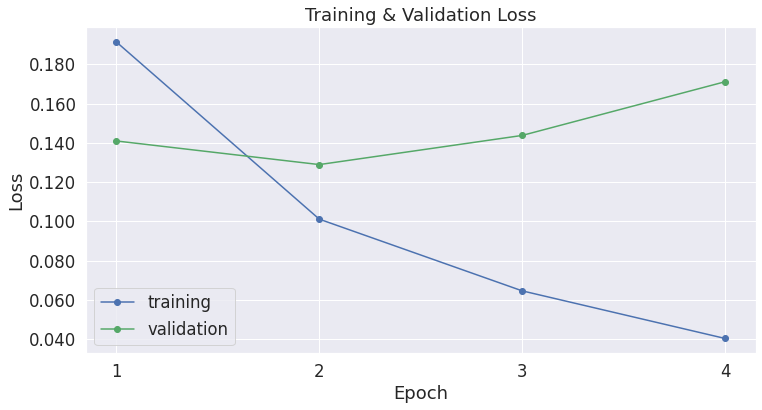

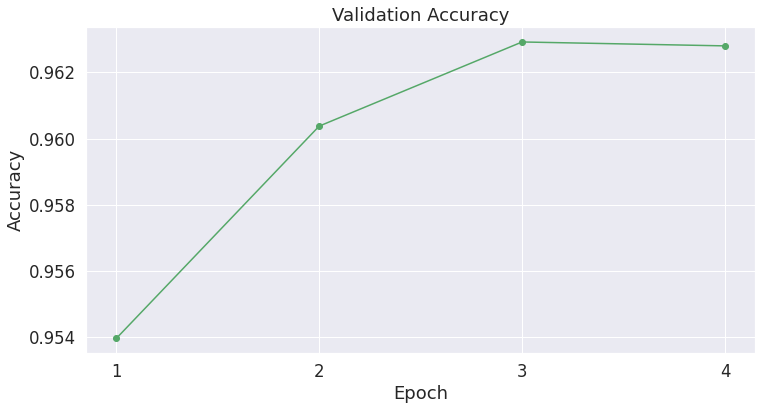

In [ ]:
print_model_name(bert)
plot_loss_curves(bert_stats_df)
plot_accuracy(bert_stats_df)

As it can be seen, the validation loss increases from the second epoch, whereas the training decreases, so the model may have been overfitted. In contrast, the validation accuracy improves until the third epoch, and gets a bit worse in the last one. For these reasons, it is not straightforward to determine which model is going to generalize better. Taking into account that the best accuracy has been obtained in the **third epoch**, and the validation loss is not much larger than in the second, the BERT saved in this epoch may be the best one.

Second model to analyze is DistilBERT.

--------------
| DistilBERT |
-------------- 



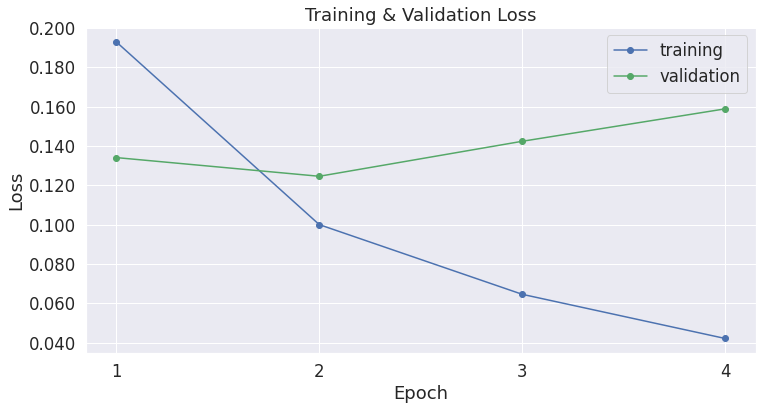

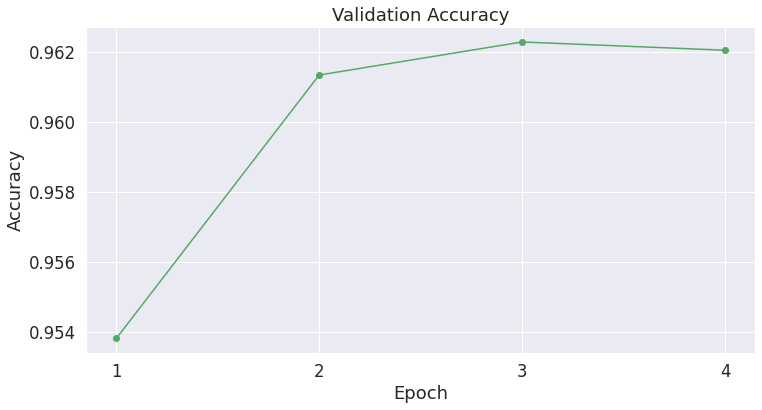

In [ ]:
print_model_name(distilbert)
plot_loss_curves(distilbert_stats_df)
plot_accuracy(distilbert_stats_df)

The same explanation can be applied in this case, what it makes sense since both models behave in the same way, the only difference is in the computational cost, and the final classifier does not change between them. For this reason, the model trained until the **third epoch** may be the best option.

### 1.5.2 - Save hyperparameters and training results

The selected hyperparameters as well as the obtained results of both models are stored in the corresponding folder. Mention the hyperparameters are stored in *json* format, whereas the training results are stored in *xlsx* and *json* format.

In [ ]:
hyperparams = get_hyperparameters(batch_sizes, classifier_params, training_params)
save_hyperparameters(multiclass_dir, hyperparams)

Hyperparameters saved in multiclass/hyperparameters.json


In [ ]:
save_statistics(multiclass_dir/'bert', 'training_stats',
                bert_stats_df,
                bert_trainer.training_stats
)

Statistics saved in multiclass/bert/training_stats.xlsx
JSON file saved in multiclass/bert/training_stats.json


In [ ]:
save_statistics(multiclass_dir/'distilbert', 'training_stats',
                distilbert_stats_df,
                distilbert_trainer.training_stats
)

Statistics saved in multiclass/distilbert/training_stats.xlsx
JSON file saved in multiclass/distilbert/training_stats.json
Statistics saved in multiclass/distilbert/training_stats.xlsx
JSON file saved in multiclass/distilbert/training_stats.json


## 1.6 - Evaluation

Once the models are fine-tuned, they are evaluated respect the test set. Nevertheless, first it is advisable to select which checkpoint (model trained until certain epoch) may generalise better. In both cases has been explained that the best model corresponds with **epoch 3**.

In [ ]:
#@markdown BERT
best_epoch =  3#@param {type:"integer"}
load_best_model(multiclass_dir/'bert', bert_trainer, epoch=best_epoch)

In [ ]:
#@markdown DistilBERT
best_epoch =  3#@param {type:"integer"}
load_best_model(multiclass_dir/'distilbert', distilbert_trainer, epoch=best_epoch)

The trainer object defined for each model can be used with its function `evaluate` setting `test=True`.

In [ ]:
bert_probs, bert_preds, bert_test_stats = bert_trainer.evaluate(test=True)


Using GPU Tesla P100-PCIE-16GB 

--------
| BERT |
-------- 

Evaluation: 2641 batches

 Accuracy  |  Eval Loss   |  Elapsed 
-------------------------------------
 0.964205  |   0.132820   |  0:02:05 
-------------------------------------




BERT obtains a very high accuracy, taking into account that the problem is multiclass, no binary.

In [ ]:
distilbert_probs, distilbert_preds, distilbert_test_stats = distilbert_trainer.evaluate(test=True)


Using GPU Tesla P100-PCIE-16GB 

--------------
| DistilBERT |
-------------- 

Evaluation: 2641 batches

 Accuracy  |  Eval Loss   |  Elapsed 
-------------------------------------
 0.963566  |   0.135481   |  0:01:04 
-------------------------------------




In the case of DistilBERT, the performance is also very high, although less accurate than BERT, 0.06%, a negligible percentage. Mention than the evaluation loss is also higher, but again the difference is insignificant. What is really important is the difference in the computation time, where DistilBERT is again **50% faster** than BERT.

In order to see how good is predicted each category or class, the confusion matrix for both models is plotted. The labels and their corresponding categories are the following.

In [ ]:
categories = list(label_dic.values())
label_dic

{0: 'business', 1: 'science', 2: 'entertainment', 3: 'health'}

First model is BERT.

--------
| BERT |
-------- 



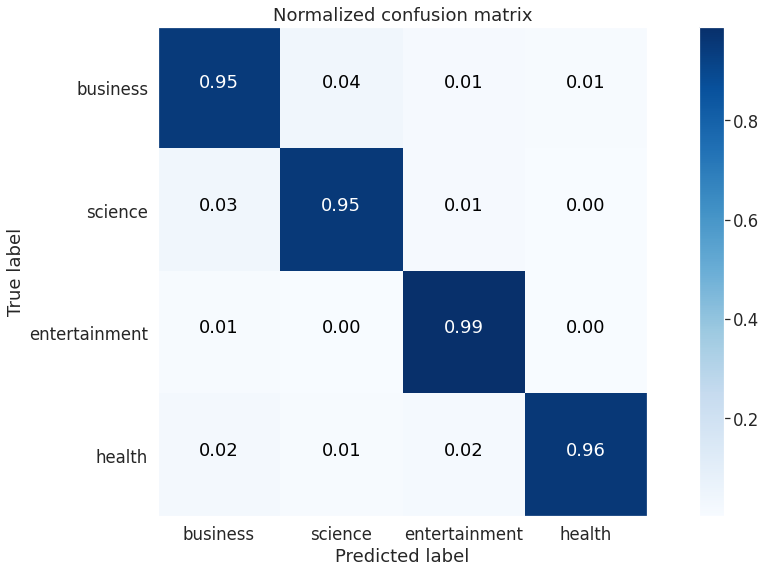

In [ ]:
bert_conf = confusion_matrix(datasets['test'].labels, bert_preds)
print_model_name(bert)
plot_confusion_matrix(bert_conf, categories)

As expected, the performance is great and all the classes are well predicted with minor missclassifications.

--------------
| DistilBERT |
-------------- 



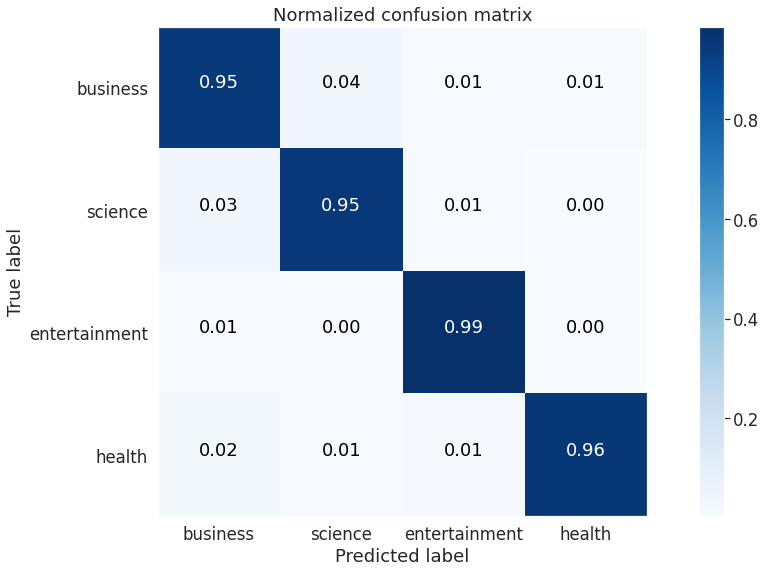

In [ ]:
distilbert_conf = confusion_matrix(datasets['test'].labels, distilbert_preds)
print_model_name(distilbert)
plot_confusion_matrix(distilbert_conf, categories)

Similar results are obtained with DistilBERT.

Finally, in order to compare how sure both models make the predictions, a table with few test samples is printed, with the obtained probabilities and predictions by model.

In [ ]:
df = datasets['test'].sample(5)
df = df.drop(columns=['labels'])
df['BERT pred'] = np.array([label_dic[label] for label in bert_preds[df.index]])
df['BERT prob'] = np.amax(bert_probs, axis=1)[df.index]
df['DistilBERT pred'] = np.array([label_dic[label] for label in distilbert_preds[df.index]])
df['DistilBERT prob'] = np.amax(distilbert_probs, axis=1)[df.index]
pd.set_option("max_colwidth", 150)
df

,text,category,BERT pred,BERT prob,DistilBERT pred,DistilBERT prob
8940,"'Dancing with the Stars' season 18 premiere recap: Some dazzled, some didn't",entertainment,entertainment,0.999934,entertainment,0.999917
9064,April 15 not really a deadline for most taxpayers,business,business,0.999299,business,0.999660
23725,Merger Costs Drive Chrysler 1Q Loss,business,business,0.997724,business,0.998304
9533,Rihanna shrugs off Charlie Sheen's invite — and then his Twitter tirade,entertainment,entertainment,0.999953,entertainment,0.999943
84268,US Alzheimer's Rate Is Dropping,health,health,0.999655,health,0.999682


As it can be seen, both BERT and DistilBERT are very accurate in the predictions, obtaining probabilities close to 1 for the correct category.

### 1.6.1 - Save test results

As with the training, the test results of both models are stored in the corresponding folder. In this case the format is *json*.

In [ ]:
save_statistics(multiclass_dir/'bert', 'test_stats',
                dic=bert_test_stats)

JSON file saved in multiclass/bert/test_stats.json


In [ ]:
save_statistics(multiclass_dir/'distilbert', 'test_stats',
                dic=distilbert_test_stats)

JSON file saved in multiclass/distilbert/test_stats.json


With the next function, the folder where all data and models have been stored is downloaded.

In [ ]:
#download_folder(multiclass_dir)

# 2 - Multilabel classification

This task is similar to the previous one, but in this case more than one class can be assigned to a single sample. The dataset from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) is employed, which groups comments from Wikipedia’s talk page edits. The possible categories are:

- Toxic.
- Severe toxic.
- Obscene.
- Threat.
- Insult.
- Identity hate.

## 2.1 - Setup

As before, it is recommended the use of a GPU.

> In case of running it from Colab, Google's GPUs can be used. Make sure to select GPU from *Runtime > Change runtime type > Hardware accelerator > GPU*.

In [ ]:
device = set_up_runtime()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


The same device is used for both models in order to compare the spent time.

## 2.2 - Load data

The dataset is directly downloaded from [Kaggle](https://www.kaggle.com/) making use of its API. For this reason it is required to use a Kaggle's token ([tutorial](https://www.kaggle.com/docs/api)) and run next cell to load it.

> In case of running it from Colab, disable the third-party cookies in this site, otherwise it could throw an error.

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


As before, all the employed data as well as the models are stored in a folder called **multilabel**.

In [ ]:
# Dataset directory
multilabel_dir = Path('multilabel')
if not os.path.exists(multilabel_dir):
    !mkdir $multilabel_dir

# Download the file (if we haven't already)
if not os.path.exists('./jigsaw-toxic-comment-classification-challenge.zip'):
    !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

# Unzip the dataset (if we haven't already)
data_path = multilabel_dir/'train.csv'
if not os.path.exists(data_path):
    !unzip jigsaw-toxic-comment-classification-challenge.zip
    !unzip train.csv.zip
    shutil.move('train.csv', data_path)
    os.remove('jigsaw-toxic-comment-classification-challenge.zip')
    os.remove('test.csv.zip')
    os.remove('test_labels.csv.zip')
    os.remove('train.csv.zip')
    os.remove('sample_submission.csv.zip')

 63% 33.0M/52.6M [00:00<00:00, 67.1MB/s]
100% 52.6M/52.6M [00:00<00:00, 92.0MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               


The original data is composed by the text and one column per category, indicating if it is presented (1) or not (0) in the sentence. The `id` column can be removed.

In [ ]:
original_dataset = pd.read_csv(data_path)
os.remove(data_path)
pd.set_option("max_colwidth", 150)
original_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I ...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits in...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


As commented, there are 6 categories, stored in `categories`.

In [ ]:
categories = original_dataset.columns[2:].values.tolist()
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### 2.2.1 - Cleaning data

The cleaning process consist of the following steps:

* Remove the `id` column.
* Remove titles larger than 200 word, because they had a bad format.
* Remove special characters as: ", '\n'.
* List all the categories.
* Rename columns: useful for preprocessing with the `Processing` class.

In [ ]:
dataset = original_dataset.drop(['id'], axis=1)
dataset = dataset.rename(columns={'comment_text': 'text'})

# Remove bad titles, longer than 512
dataset = dataset[dataset.text.str.len() < 200].reset_index(drop=True)

# Remove characters
dataset['text'] = dataset['text'].apply(lambda x: x.replace('\n', ' '))
dataset['text'] = dataset['text'].apply(lambda x: x.replace('"', ''))

dataset['labels'] = dataset.iloc[:, 1:].values.tolist()

Finally this is the used dataset, in which each sample is composed by text and the corresponding labels.

In [ ]:
dataset.sample(5)

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
35197,Check out the history ! — | |The WelshBuzzard| —,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
57829,Keep this under your hat but i heard he was gay dude.,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
67831,"support ship Ships of this class would effectively be destroyers, or big frigates?",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14703,Brilliant. Thanks so much.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
74253,. All of them are confirmed by officials that their death are related to the operation,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


### 2.2.2 - Resize dataset 

As before, the size of the dataset can be reduced.

In [ ]:
#@title { vertical-output: true }
#@markdown Percentage of dataset to use %
perc = 100 #@param {type:"slider", min:1, max:100, step:1}
re_dataset = resize_dataset(dataset, perc)

Samples: 78186     


### 2.2.3 - Data splitting

The same strategy is followed to split the data in training, validation and test.

In [ ]:
#@title { vertical-output: true }
#@markdown Respect the total data:
train_perc = 80 #@param {type:"slider", min:1, max:100, step:1}
#@markdown Respect the training data:
val_perc = 10 #@param {type:"slider", min:1, max:100, step:1}
datasets = data_splitting(re_dataset, train_perc, val_perc)

----------------------------------------------------------
|  Total samples  |  Training  | Validation |    Test    |
----------------------------------------------------------
|      78186      |   56294    |    6255    |   15637    |
----------------------------------------------------------


In this case, the problem of imbalanced classes may also be present.

> It is really important having at least one sample per class and set, otherwise some erros could raise along the notebook. Choose a resize which fulfills this condition.

In [ ]:
print(140*'-')
print(f"| {'Split':^10} | {'Total samples':^15} | {categories[0]:^15} | {categories[1]:^15} | {categories[2]:^15} | {categories[3]:^15} | {categories[4]:^15} | {categories[5]:^15} |")
print(140*'-')
print(f"| {'training':^10} | {len(datasets['train']):^15} | {datasets['train'][categories[0]].sum():^15} | {datasets['train'][categories[1]].sum():^15} | {datasets['train'][categories[2]].sum():^15} | {datasets['train'][categories[3]].sum():^15} | {datasets['train'][categories[4]].sum():^15} | {datasets['train'][categories[5]].sum():^15} |")
print(140*'-')
print(f"| {'validation':^10} | {len(datasets['val']):^15} | {datasets['val'][categories[0]].sum():^15} | {datasets['val'][categories[1]].sum():^15} | {datasets['val'][categories[2]].sum():^15} | {datasets['val'][categories[3]].sum():^15} | {datasets['val'][categories[4]].sum():^15} | {datasets['val'][categories[5]].sum():^15} |")
print(140*'-')
print(f"| {'test':^10} | {len(datasets['test']):^15} | {datasets['test'][categories[0]].sum():^15} | {datasets['test'][categories[1]].sum():^15} | {datasets['test'][categories[2]].sum():^15} | {datasets['test'][categories[3]].sum():^15} | {datasets['test'][categories[4]].sum():^15} | {datasets['test'][categories[5]].sum():^15} |")
print(140*'-')

--------------------------------------------------------------------------------------------------------------------------------------------
|   Split    |  Total samples  |      toxic      |  severe_toxic   |     obscene     |     threat      |     insult      |  identity_hate  |
--------------------------------------------------------------------------------------------------------------------------------------------
|  training  |      56294      |      7297       |       853       |      4209       |       236       |      3943       |       691       |
--------------------------------------------------------------------------------------------------------------------------------------------
| validation |      6255       |       793       |       98        |       472       |       23        |       428       |       81        |
--------------------------------------------------------------------------------------------------------------------------------------------
|    test    

As it can be seen, there are some categories as *severe_toxic*, *threat* or *identity_hate*, whose representation is minor in the three sets. In spite of that, the imbalance is not strong enough to require some processing. In addition to that, BERT and DistilBERT work so well that they can lead with type of data.

The three sets (training, validation and test) used to train the models are stored in the corresponding folder.

In [ ]:
save_used_data(multilabel_dir, datasets)

Dataset train.csv saved in multilabel/data/train.csv
Dataset val.csv saved in multilabel/data/val.csv
Dataset test.csv saved in multilabel/data/test.csv


## 2.3 - Pre-processing data

The process is exactly the same than before, with the only difference that the labels are stored as *float*, instead of *long* as in the previous case. That is because different loss functions are employed, where in each one a certain type of label is required.

As before, an object of `Processing` is created.

In [ ]:
processing = Processing(datasets)

The tokenizer is loaded and stored as attribute in `processing`.

In [ ]:
print('Loading tokenizer...')
processing.tokenizer = BertTokenizerFast.from_pretrained(BERT_NAME)

Loading tokenizer...


Obtain the maximum length in the dataset.

In [ ]:
processing.get_max_len()

Calculating largest length...
The largest length is 145


Encode the three sets, taking into account the mentioned aspect with the labels, notice that `long_labels=False`.

In [ ]:
processing.encode_datasets(long_labels=False)

Processing train dataset...
Processing val dataset...
Processing test dataset...


### 2.3.1 - Batch sizes

Select the batch sizes for the three sets.

In [ ]:
TRAIN_BATCH_SIZE =  64#@param {type:"integer"}
VAL_BATCH_SIZE =  32#@param {type:"integer"}
TEST_BATCH_SIZE =  32#@param {type:"integer"}

batch_sizes = {
    'train' : TRAIN_BATCH_SIZE,
    'val' : VAL_BATCH_SIZE,
    'test' : TEST_BATCH_SIZE,
}

Generate the dataloaders.

In [ ]:
processing.get_dataloaders(batch_sizes)

Generating train dataloader...
Generating val dataloader...
Generating test dataloader...


The employed tokenizer as well as the dictionary are also stored in the corresponding folder.

In [ ]:
save_tokenizer(multilabel_dir, processing.tokenizer)

Tokenizer saved in multilabel/tokenizer


## 2.4 - Declaration of the models

In this case the models are exactly the same, it is only required changing the number of neurons of the output layer from the neural network employed as classifier. Now there are 6 classes or categories instead of 4. Again, this block is composed by a multilayer perceptron with only one hidden layer.

In [ ]:
# Create the BertClassfier class
class BertMultilabel(nn.Module):
    def __init__(self, in_classifier=768, dropout=0.3, freeze_bert=False):
        super(BertMultilabel, self).__init__()

        self.name = 'BERT'

        # Instantiate BERT model
        self.base = BertModel.from_pretrained(BERT_NAME)

        # Instantiate an one-layer feed-forward classifier
        H = in_classifier
        D_in = self.base.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(H, len(categories))
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.base.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.base(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # outputs[0] = last_hidden_state
        # last_hidden_state dimension: (n_batches x words x inner_dim_BERT)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.head(last_hidden_state_cls)

        return logits

In [ ]:
# Create the BertClassfier class
class DistilBertMultilabel(nn.Module):
    def __init__(self, in_classifier=768, dropout=0.3, freeze_bert=False):
        super(DistilBertMultilabel, self).__init__()

        self.name = 'DistilBERT'

        # Instantiate DistilBERT model
        self.base = DistilBertModel.from_pretrained(DISTILBERT_NAME)

        # Instantiate an one-layer feed-forward classifier
        H = in_classifier
        D_in = self.base.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(H, len(categories))
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.base.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.base(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # outputs[0] = last_hidden_state
        # last_hidden_state dimension: (n_batches x words x inner_dim_BERT)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.head(last_hidden_state_cls)

        return logits

### 2.4.1 - Classifier hyperparameters

As before the classifier hyperparameters can be selected.

In [ ]:
#@markdown Size classifier layer:
IN_CLASSIFIER =  50#@param {type:"integer"}
#@markdown Classifier droput probability:
DROPOUT = 0.2 #@param {type:"number"}
classifier_params = {
    'in_classifier': IN_CLASSIFIER,
    'dropout': DROPOUT
}
bert = BertMultilabel(IN_CLASSIFIER, DROPOUT)
distilbert = DistilBertMultilabel(IN_CLASSIFIER, DROPOUT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_no

### 2.4.2 - Models comparison

The models can be compared as previously, although the unique differences are going to be in the classifier (head).

In [ ]:
#@markdown Select whole model, only pretrained BERT or the classifier
model = "DistilBERT" #@param ["BERT", "DistilBERT"]
block = "head" #@param ["all", "base", "head"]
if model=='BERT':
    mod = bert
else:
    mod = distilbert
show_model(mod, block)

Sequential(
  (0): Linear(in_features=768, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=50, out_features=6, bias=True)
)


The number of parameters of both models are going to be the same excluding the classifier, as mentioned.

In [ ]:
#@markdown Select whole model, only pretrained BERT or the classifier
model = "DistilBERT" #@param ["BERT", "DistilBERT"]
show_layers = False #@param ["True", "False"] {type:"raw"}
show_params(model, show_layers)

Total number of parameters = 66401636


The relation between the size of the models is the same, being DistilBERT **40% smaller** than BERT.

## 2.5 - Fine-tuning

The `TrainerMultilabel` is in charge of training the models. There are two important differences respect the previous design:

1. Instead of using the cross entropy loss, it is employed the [**binary cross entropy**](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), which evaluates each class independently of the rest.

2. The validation set is not evaluated respect the accuracy, but is used the **hamming score**, which is the fraction of correct predictions compared to the total labels. This is similar to accuracy, and in fact they are interchangeable. In next cell the function is implemented.

In [ ]:
def get_hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
class TrainerMultilabel():
    def __init__(self, model, dataloaders, params, device):

        # Get the model
        self.model = model
        self.device = device
        self.model.to(self.device)
        # Dataloaders
        self.dataloaders = dataloaders
        # Epochs
        self.epochs = params['epochs']
        # Loss
        self.loss = nn.BCEWithLogitsLoss()
        #Optimizer
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=params['learning_rate'], 
            eps=params['epsilon']
        )
        # Scheduler
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0, 
            num_training_steps=len(self.dataloaders['train']) * self.epochs
        )
        # To store the results
        self.training_stats = []
        

    def set_seed(self, seed_value=seed):
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)


    def train(self, print_every=50):
        # Set seed
        self.set_seed()

        # Info training
        info_device(self.device)
        print_model_name(self.model)

        # Init total time
        total_time = 0

        # For each epoch
        for epoch_i in range(self.epochs):

            # =======================================
            #               Training
            # =======================================

            # Print the header of the result table
            print(f'============ Epoch {epoch_i+1} / {self.epochs} ============\n')
            n_batches = len(self.dataloaders['train'])
            print(f'Training: {n_batches} batches\n')
            print(f"{'Batch':^10} | {'Train Loss':^12} | {'Elapsed':^9}")
            print("-"*37)

            # Reset tracking variables at the beginning of each epoch
            train_loss, batch_counts = 0, 0

            # Put the model into the training mode
            self.model.train()

            # Measure the elapsed time of each epoch
            train_st = time.time()

            # For each batch in the training set
            for step, batch in enumerate(self.dataloaders['train'], 1):

                batch_counts += 1

                # Load batch to device
                ids, mask, labels = tuple(t.to(self.device) for t in batch)

                # Zero out any previously calculated gradients
                self.model.zero_grad()

                # Perform a forward pass. This will return logits.
                logits = self.model(ids, mask)

                # Compute loss and accumulate the loss values
                loss = self.loss(logits, labels)
                train_loss += loss.item()

                # Perform a backward pass to calculate gradients
                loss.backward()

                # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and the learning rate
                self.optimizer.step()
                self.scheduler.step()

                # Print the loss values and time elapsed for every specified batches
                if (step % print_every == 0) or (step == n_batches):

                    # Calculate time elapsed for batches
                    train_time = time.time() - train_st

                    # Calculate average train loss
                    avg_train_loss = train_loss/batch_counts

                    # Print training results
                    print(f"{step:^10} | {avg_train_loss:^12.6f} | {format_time(train_time):^9}")

            print("-"*37, '\n')

            # =======================================
            #               Validation
            # =======================================

            # Measure the model's performanc on the validation set
            _, _, val_stats = self.evaluate()

            # Compute total time
            total_time = total_time + train_time + val_stats['eval time']

            # Record all statistics from this epoch
            self.training_stats.append({
                    'epoch': epoch_i + 1,
                    'train_loss': avg_train_loss,
                    'val_loss': val_stats['eval loss'],
                    'hamming': val_stats['hamming'],
                    'train_time': format_time(train_time),
                    'val_time': format_time(val_stats['eval time']),
                    'total_time': format_time(total_time)
            })

            # Save model after one epoch
            save_model(multilabel_dir, self.model, epoch_i+1)
            print('\n')

        # Finished all epochs
        print("\nTraining completed!\n")
        print(f'The total elapsed time was {format_time(total_time)}')


    def evaluate(self, thresholds=None, test=False):
        # Print info if specified
        if test:
            info_device(self.device)
            print_model_name(self.model)
            eval_dataloader = self.dataloaders['test']
        else:
            eval_dataloader = self.dataloaders['val']

        # =======================================
        #               Evaluation
        # =======================================

        # Print the header of the result table
        print(f'Evaluation: {len(eval_dataloader)} batches\n')
        print(f"{'Hamming':^10} | {'Eval Loss':^12} | {'Elapsed':^9}")
        print("-"*37)

        # Put the model into the evaluation mode
        self.model.eval()

        # Predictions
        all_logits = torch.tensor([], device=self.device)
        all_labels = torch.tensor([], device=self.device)

        # Tracking variables
        eval_loss = 0

        # Set time
        eval_st = time.time()
    
        # For each batch in the evaluation set
        for batch in eval_dataloader:

            # Load batch to device           
            ids, mask, labels = tuple(t.to(self.device) for t in batch)

            # Compute logits
            with torch.no_grad(): 
                logits = self.model(ids, mask)
            all_logits = torch.cat((all_logits, logits))

            # Compute loss
            loss = self.loss(logits, labels)
            eval_loss += loss.item()

            # Get labels
            all_labels = torch.cat((all_labels, labels))

        # Compute probabilities
        probs = torch.sigmoid(all_logits).cpu().detach()

        # Compute predictions
        if thresholds is None:
            preds = torch.where(probs >= 0.5, 1, 0)
        else:
            preds = torch.where(probs >= thresholds, 1, 0)

        # Compute hamming score
        hamming_score = get_hamming_score(all_labels.cpu(), preds.cpu())

        # Compute the average loss over the validation set
        avg_eval_loss = eval_loss/len(eval_dataloader)

        # Compute elapsed time
        eval_time = time.time() - eval_st

        # Print results
        print(f"{hamming_score:^10.6f} | {avg_eval_loss:^12.6f} | {format_time(eval_time):^9}")
        print("-"*37)
        print('\n')

        # Get the statistics
        eval_stats = {
            'hamming': hamming_score,
            'eval loss': avg_eval_loss,
            'eval time': eval_time
        }

        return probs.numpy(), preds.numpy(), eval_stats

### 2.5.1 - Training hyperparameters

Same hyperparameters as before can be selected.

In [ ]:
LEARNING_RATE = 5e-5 #@param {type:"number"}
EPSILON = 1e-8 #@param {type:"number"}
EPOCHS =  4#@param {type:"integer"}

training_params = {
    'learning_rate': LEARNING_RATE,
    'epsilon': EPSILON,
    'epochs': EPOCHS
}

bert_trainer = TrainerMultilabel(
    bert,
    processing.dataloaders,
    training_params,
    device
)

distilbert_trainer = TrainerMultilabel(
    distilbert,
    processing.dataloaders,
    training_params,
    device
)

Once the trainers are defined, the models can be trained.

In [ ]:
bert_trainer.train()


Using GPU Tesla P100-PCIE-16GB 

--------
| BERT |
-------- 

============ Epoch 1 / 4 ============

Training: 880 batches

  Batch    |  Train Loss  |  Elapsed 
-------------------------------------
    50     |   0.311268   |  0:00:40 
   100     |   0.244224   |  0:01:21 
   150     |   0.206637   |  0:02:01 
   200     |   0.181952   |  0:02:41 
   250     |   0.164482   |  0:03:21 
   300     |   0.151304   |  0:04:01 
   350     |   0.141774   |  0:04:42 
   400     |   0.133194   |  0:05:22 
   450     |   0.126047   |  0:06:02 
   500     |   0.119894   |  0:06:42 
   550     |   0.115072   |  0:07:22 
   600     |   0.110770   |  0:08:02 
   650     |   0.107141   |  0:08:42 
   700     |   0.103812   |  0:09:22 
   750     |   0.100954   |  0:10:02 
   800     |   0.098156   |  0:10:42 
   850     |   0.095891   |  0:11:22 
   880     |   0.094784   |  0:11:46 
------------------------------------- 

Evaluation: 196 batches

 Hamming   |  Eval Loss   |  Elapsed 
------------

In [ ]:
distilbert_trainer.train()


Using GPU Tesla P100-PCIE-16GB 

--------------
| DistilBERT |
-------------- 

============ Epoch 1 / 4 ============

Training: 880 batches

  Batch    |  Train Loss  |  Elapsed 
-------------------------------------
    50     |   0.388715   |  0:00:20 
   100     |   0.313589   |  0:00:41 
   150     |   0.268281   |  0:01:01 
   200     |   0.236360   |  0:01:21 
   250     |   0.213195   |  0:01:41 
   300     |   0.194649   |  0:02:02 
   350     |   0.180966   |  0:02:22 
   400     |   0.168873   |  0:02:42 
   450     |   0.158800   |  0:03:02 
   500     |   0.150344   |  0:03:23 
   550     |   0.143114   |  0:03:43 
   600     |   0.136895   |  0:04:03 
   650     |   0.131740   |  0:04:23 
   700     |   0.127026   |  0:04:44 
   750     |   0.122867   |  0:05:04 
   800     |   0.119111   |  0:05:24 
   850     |   0.115830   |  0:05:44 
   880     |   0.114079   |  0:05:56 
------------------------------------- 

Evaluation: 196 batches

 Hamming   |  Eval Loss   |  Ela

The training loss is progressively reduced. In next cell the training statistics are stored in data frames.

In [ ]:
# Create a DataFrame from our training statistics.
bert_stats_df = pd.DataFrame(data=bert_trainer.training_stats)
distilbert_stats_df = pd.DataFrame(data=distilbert_trainer.training_stats)

# Use the 'epoch' as the row index.
bert_stats_df = bert_stats_df.set_index('epoch')
distilbert_stats_df = distilbert_stats_df.set_index('epoch')

In [ ]:
print_model_name(bert)
bert_stats_df

--------
| BERT |
-------- 



,train_loss,val_loss,hamming,train_time,val_time,total_time
epoch,,,,,,
1,0.094784,0.048438,0.945196,0:11:46,0:00:25,0:12:11
2,0.045753,0.045861,0.934125,0:11:45,0:00:25,0:24:20
3,0.033957,0.046269,0.939297,0:11:44,0:00:25,0:36:29
4,0.026291,0.047548,0.942118,0:11:44,0:00:25,0:48:38


In [ ]:
print_model_name(distilbert)
distilbert_stats_df

--------------
| DistilBERT |
-------------- 



,train_loss,val_loss,hamming,train_time,val_time,total_time
epoch,,,,,,
1,0.114079,0.047593,0.944439,0:05:56,0:00:13,0:06:09
2,0.049229,0.045350,0.937831,0:05:56,0:00:13,0:12:18
3,0.036902,0.045316,0.941386,0:05:56,0:00:13,0:18:27
4,0.029288,0.047954,0.941972,0:05:56,0:00:13,0:24:36


Comparing the total time, DistilBERT is **50% faster** as before, and performs as well as BERT. As in the previous task, the training and validation loss curves are plotted, followed by the hamming score, which can be interpreted as the accuracy.

First model corresponds with BERT.

--------
| BERT |
-------- 



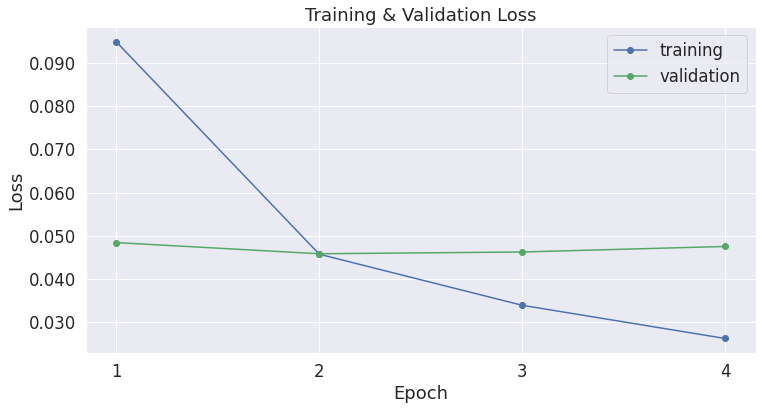

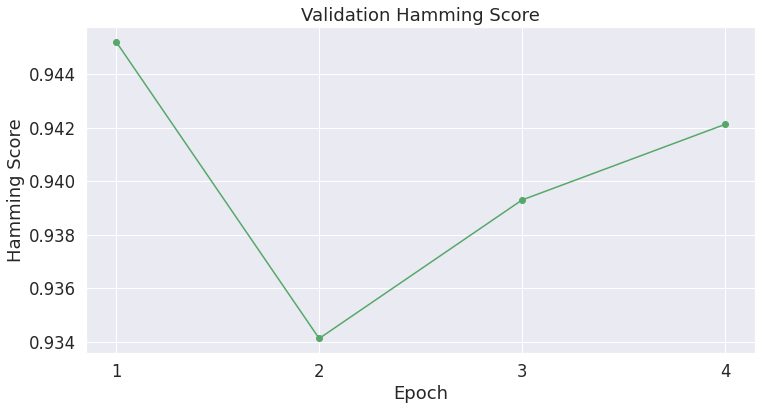

In [ ]:
print_model_name(bert)
plot_loss_curves(bert_stats_df)
plot_hamming(bert_stats_df)

In this case the validation loss is more constant, leading to think that the model may not overfit. Nevertheless, the hamming score obtained in the last epoch is higher than in the third one, with a minimum increase of the loss. For these reasons, the best considered BERT model is the one of the **fourth epoch**.

Second model to analyze is DistilBERT.

--------------
| DistilBERT |
-------------- 



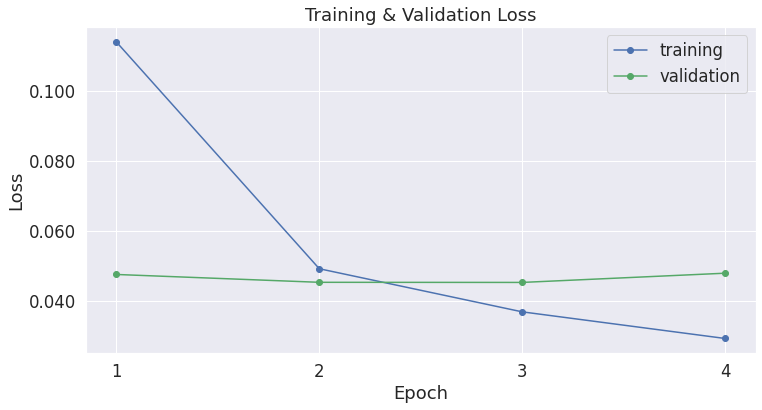

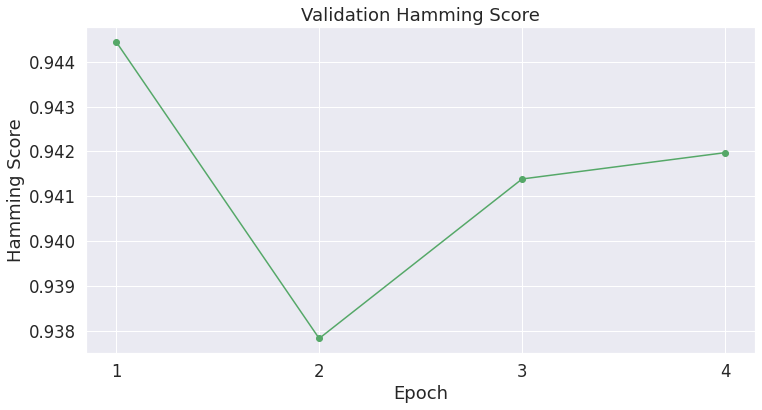

In [ ]:
print_model_name(distilbert)
plot_loss_curves(distilbert_stats_df)
plot_hamming(distilbert_stats_df)

The same situation than in the multiclassifications is presented here, the training results follow the same pattern in both models, what makes sense as explained before. Again, the best model corresponds with the **fourth epoch** in the case of DistilBERT.

### 2.5.2 - Save hyperparameters and training results

The selected hyperparameters as well as the obtained results of both models are stored in the corresponding folder. Mention the hyperparameters are stored in *json* format, whereas the training results are stored in *xlsx* and *json* format.

In [ ]:
hyperparams = get_hyperparameters(batch_sizes, classifier_params, training_params)
save_hyperparameters(multilabel_dir, hyperparams)

Hyperparameters saved in multilabel/hyperparameters.json


In [ ]:
save_statistics(multilabel_dir/'bert', 'training_stats',
                bert_stats_df,
                bert_trainer.training_stats)

Statistics saved in multilabel/bert/training_stats.xlsx
JSON file saved in multilabel/bert/training_stats.json


In [ ]:
save_statistics(multilabel_dir/'distilbert', 'training_stats',
                distilbert_stats_df,
                distilbert_trainer.training_stats)

Statistics saved in multilabel/distilbert/training_stats.xlsx
JSON file saved in multilabel/distilbert/training_stats.json


## 2.6 - Evaluation

As in the previous case, once the models are fine-tuned, they are evaluated respect the test set. In both cases has been explained that the best model corresponds with **epoch 4**.

In [ ]:
#@markdown BERT
best_epoch =  4#@param {type:"integer"}
load_best_model(multilabel_dir/'bert', bert_trainer, epoch=best_epoch)

In [ ]:
#@markdown DistilBERT
best_epoch =  4#@param {type:"integer"}
load_best_model(multilabel_dir/'distilbert', distilbert_trainer, epoch=best_epoch)

In [ ]:
bert_probs, bert_preds, bert_test_stats = bert_trainer.evaluate(test=True)


Using GPU Tesla P100-PCIE-16GB 

--------
| BERT |
-------- 

Evaluation: 489 batches

 Hamming   |  Eval Loss   |  Elapsed 
-------------------------------------
 0.939548  |   0.054059   |  0:01:02 
-------------------------------------




In [ ]:
distilbert_probs, distilbert_preds, distilbert_test_stats = distilbert_trainer.evaluate(test=True)


Using GPU Tesla P100-PCIE-16GB 

--------------
| DistilBERT |
-------------- 

Evaluation: 489 batches

 Hamming   |  Eval Loss   |  Elapsed 
-------------------------------------
 0.939555  |   0.052840   |  0:00:32 
-------------------------------------




As in the multiclass problem, both models perform very well respect the hamming score. Again, DistilBERT is significantly faster, but even a bit more accurate, 0.0007%, than BERT. The corresponding loss is also smaller.

Finally, in order to compare how sure both models make the predictions, a table with a test sample is printed, with the obtained probabilities and predictions by model.

In [ ]:
sample = datasets['test'][(datasets['test'][categories[0]]==1) | 
                          (datasets['test'][categories[1]]==1) |
                          (datasets['test'][categories[2]]==1) |
                          (datasets['test'][categories[3]]==1) |
                          (datasets['test'][categories[4]]==1) |
                          (datasets['test'][categories[5]]==1)].sample()
idx = sample.index[0]
print(sample.text.values[0], '\n')
df = pd.DataFrame(index=categories)
df['labels'] = sample.labels.values[0]
df['BERT preds'] = bert_preds[idx, :]
df['BERT probs'] = bert_probs[idx]
df['DistilBERT preds'] = distilbert_preds[idx, :]
df['DistilBERT probs'] = distilbert_probs[idx]
df

, darn, darn.  keep this here and OFF my page or i'll file another complaint.  IM DONE!!!!  HE GONE!!!!  KA-BOOOOOOOM!!!!  



,labels,BERT preds,BERT probs,DistilBERT preds,DistilBERT probs
toxic,1,1,0.959324,1,0.828968
severe_toxic,0,0,0.003004,0,0.002743
obscene,0,0,0.182350,0,0.025668
threat,0,0,0.004620,0,0.002254
insult,0,0,0.015846,0,0.025421
identity_hate,0,0,0.003184,0,0.002350


As it can be seen, both BERT and DistilBERT are very accurate in the predictions, obtaining probabilities close to 1 or 0, when the category is attributed to sentence or not, respectively.

### 2.6.1 - Save test results

As with the training, the test results of both models are stored in the corresponding folder. In this case the format is *json*.

In [ ]:
save_statistics(multilabel_dir/'bert', 'test_stats',
                dic=bert_test_stats)

JSON file saved in multilabel/bert/test_stats.json


In [ ]:
save_statistics(multilabel_dir/'distilbert', 'test_stats',
                dic=distilbert_test_stats)

JSON file saved in multilabel/distilbert/test_stats.json


With the next function, the folder where all data and models have been stored is downloaded.

In [ ]:
#download_folder(multilabel_dir)

### 2.6.2 - Optimal threshold per class

A multilabel problem can be seen as multiple binary classifications, one per category. For this reason, for each class may be an optimal threshold. 

--------------
| DistilBERT |
-------------- 



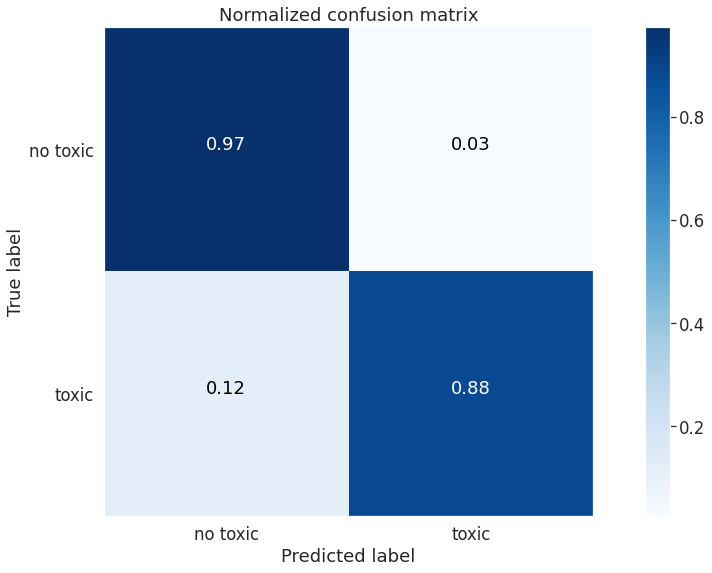

In [ ]:
#@title 
model = "DistilBERT" #@param ["BERT", "DistilBERT"]
category = "toxic" #@param ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
threshold = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

idx = categories.index(category)

if model=='BERT':
    mod = bert
    probs = bert_probs
else:
    mod = distilbert
    probs = distilbert_probs

preds_thres = np.where(probs[:, idx] >= threshold, 1, 0)
conf_thres = confusion_matrix(datasets['test'][category], preds_thres)
print_model_name(mod)
plot_confusion_matrix(conf_thres, ('no ' + category, category))

The objective is to determine which is the optimal threshold in the 6 classes and the two models, BERT and DistilBERT. Nevertheless, mention this study is done with the test set and their corresponding labels, an information which is not available in a real situation. The approach will be analyzing the training data and hope that the found thresholds generalise well with new samples.

In order to determine which is the optimal threshold, the ROC curve is employed, calculating the **geometric mean** or **G-mean**, which will seek a balance between the sensitivity (true positive rate) and the specificity (the complement of the false positive rate).


\begin{equation}
    \text{G-Mean} = \sqrt{\text{Sensitivity} \cdot \text{Specificity}} = \sqrt{\text{TPR} \cdot (1 - \text{FPR})}
\end{equation}



In [ ]:
thresholds = {'bert': {}, 'distilbert': {}}

The optimal threshold per category and model is stored in the dictionary `thresholds`. Then, the confusion matrix per class is plotted considering the new predictions.

#### Toxic

In [ ]:
idx = 0
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



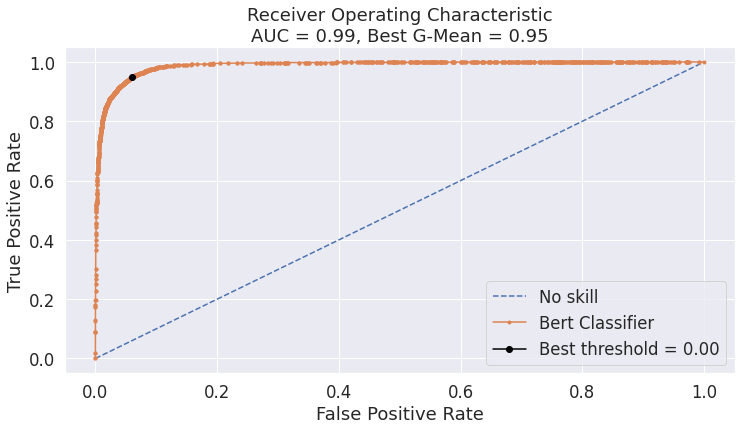

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.00



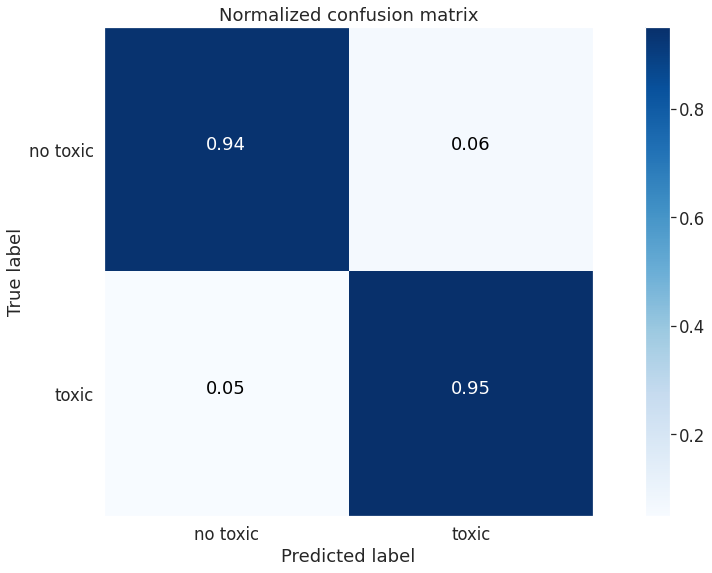

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



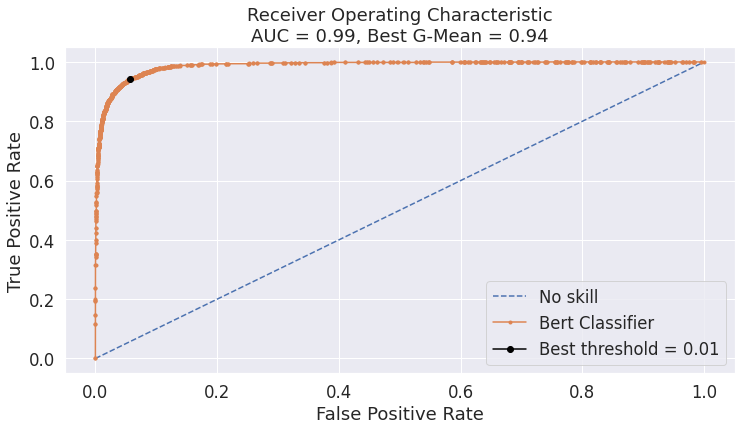

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.01



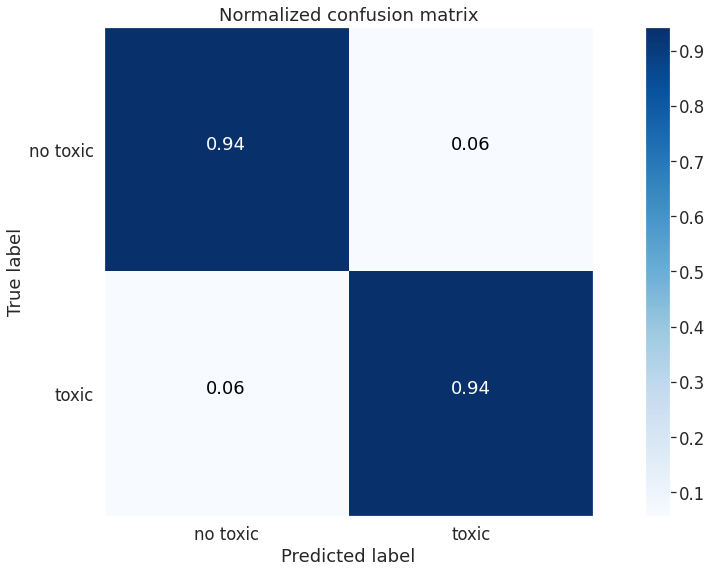

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

#### Severe toxic

In [ ]:
idx = 1
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



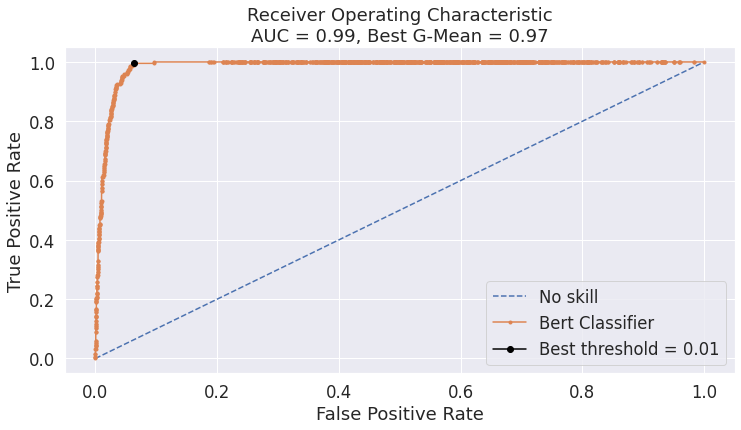

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.01



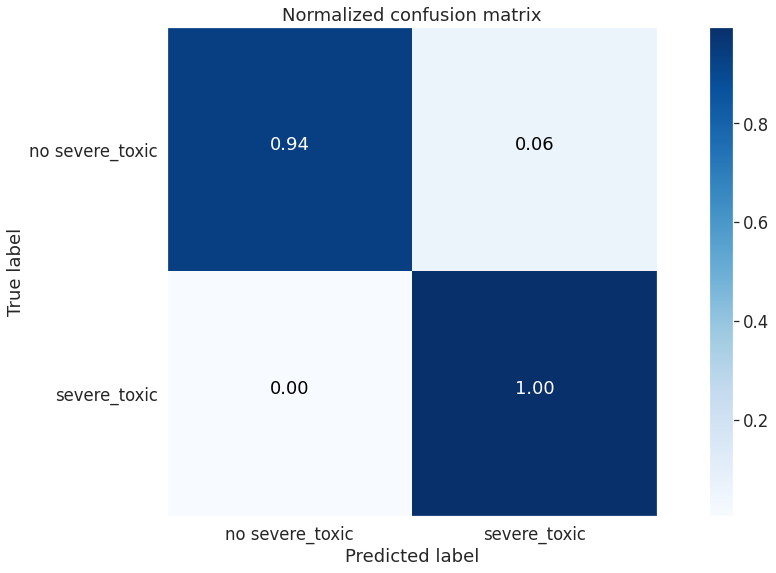

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



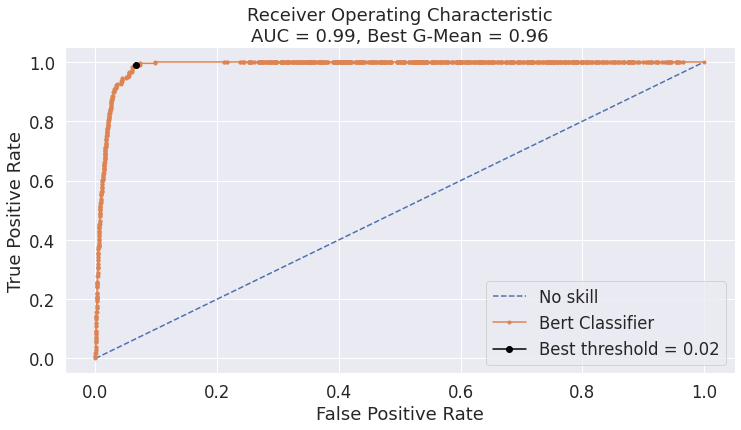

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.02



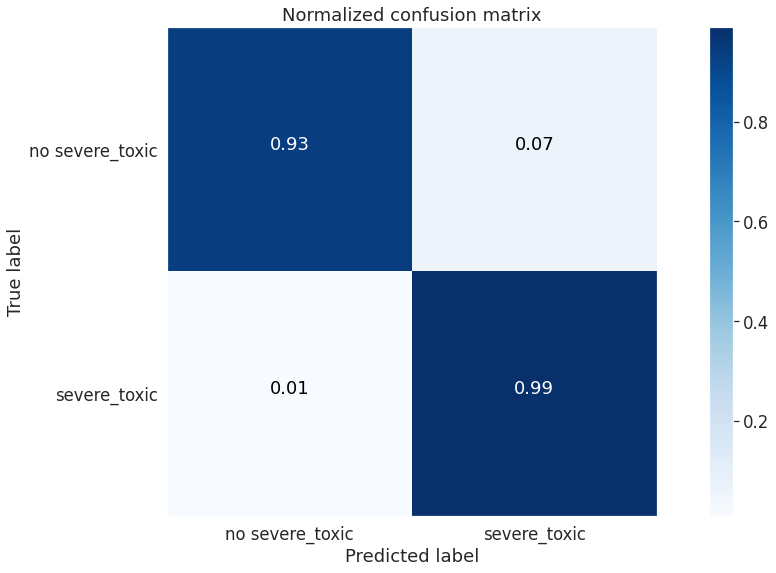

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

#### Obscene

In [ ]:
idx = 2
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



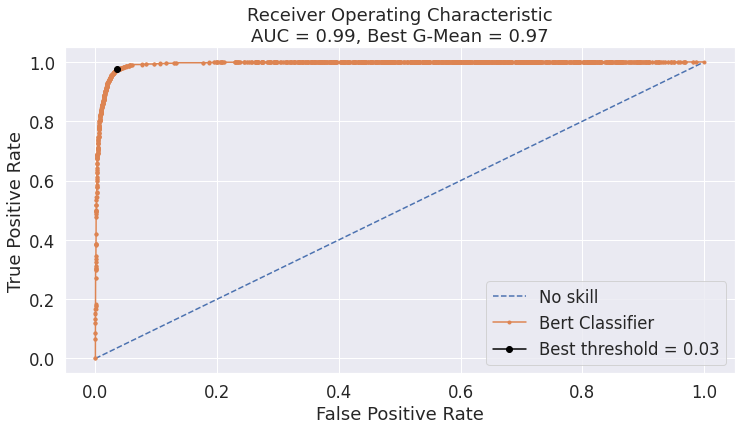

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.03



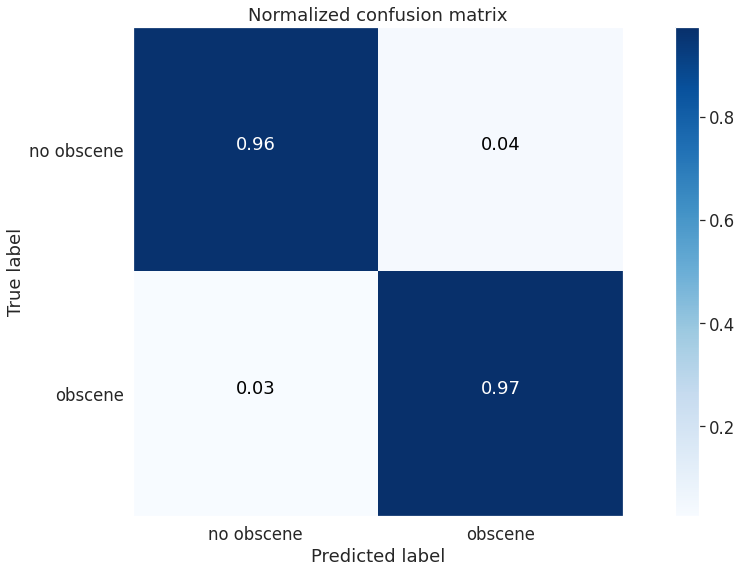

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



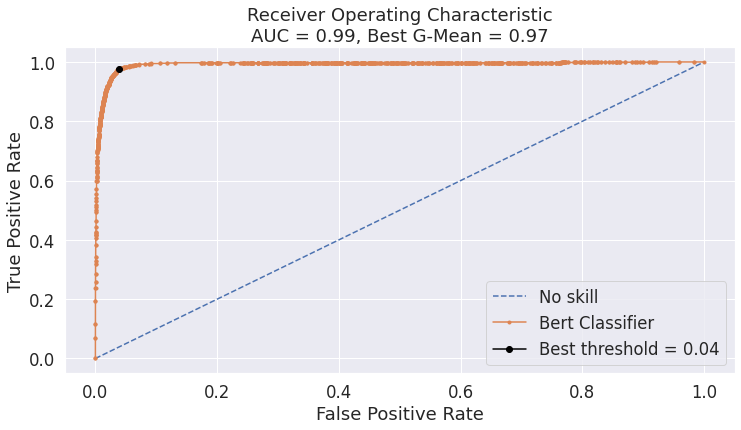

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.04



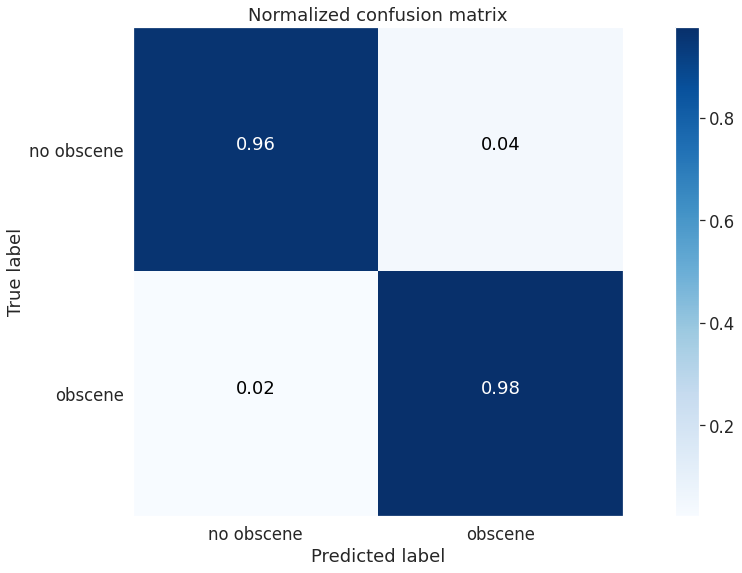

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

#### Threat

In [ ]:
idx = 3
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



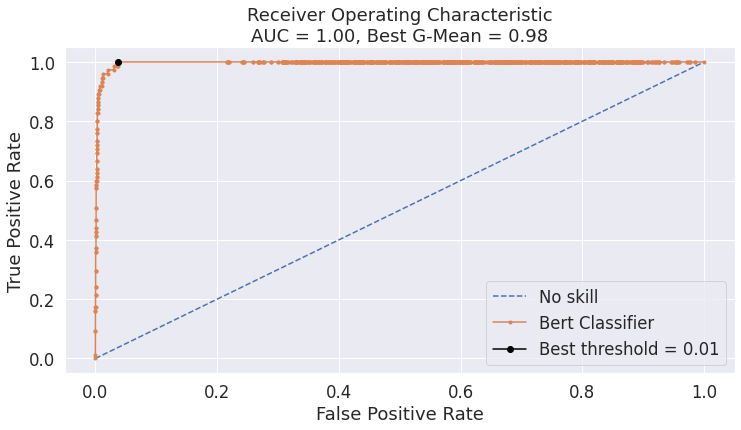

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.01



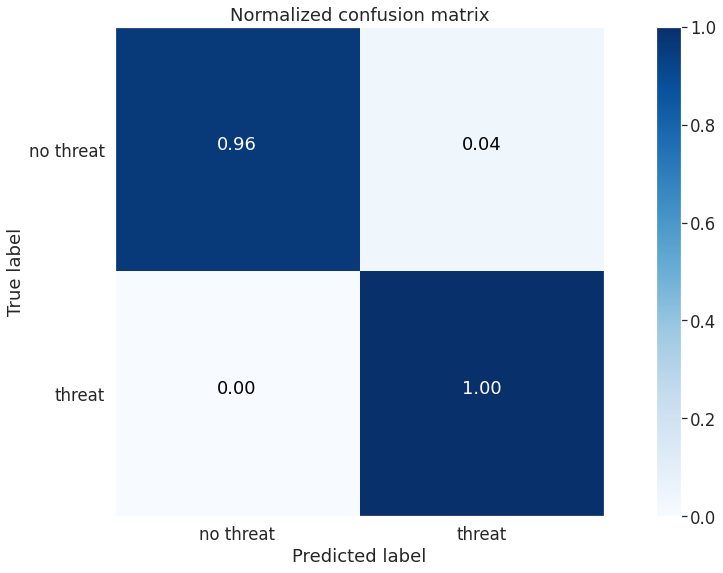

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



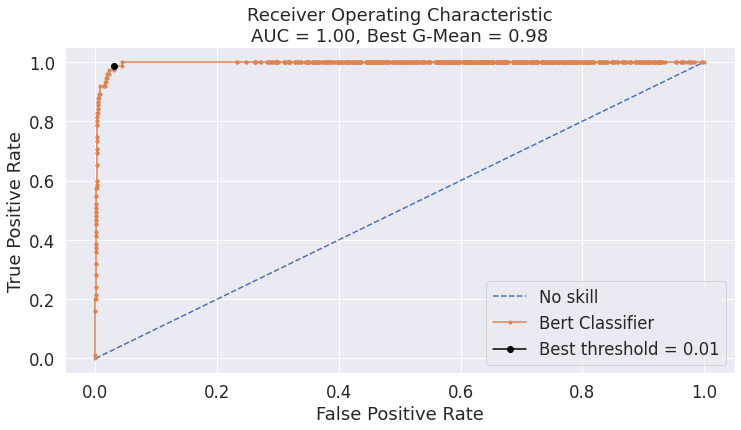

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.01



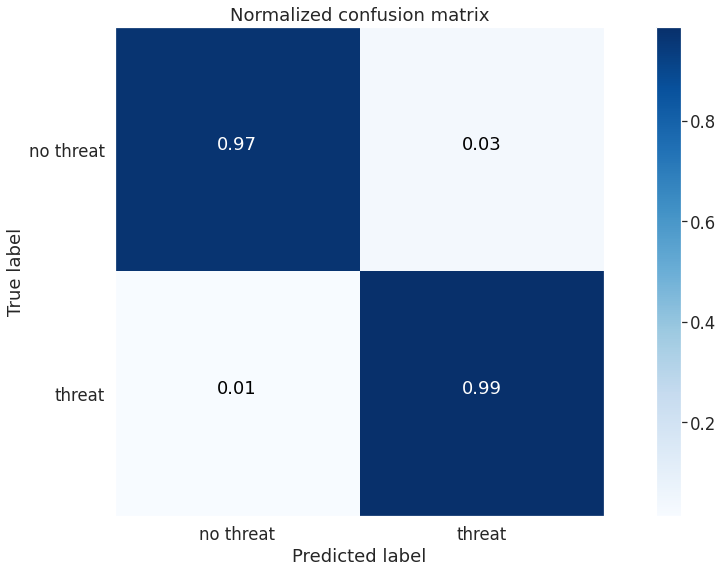

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

#### Insult

In [ ]:
idx = 4
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



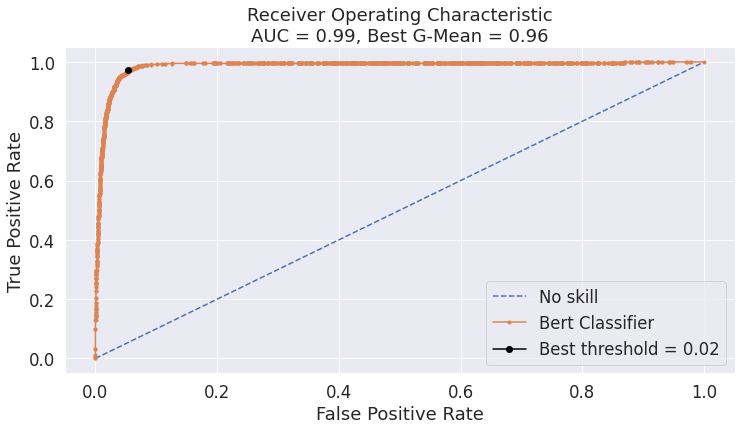

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.02



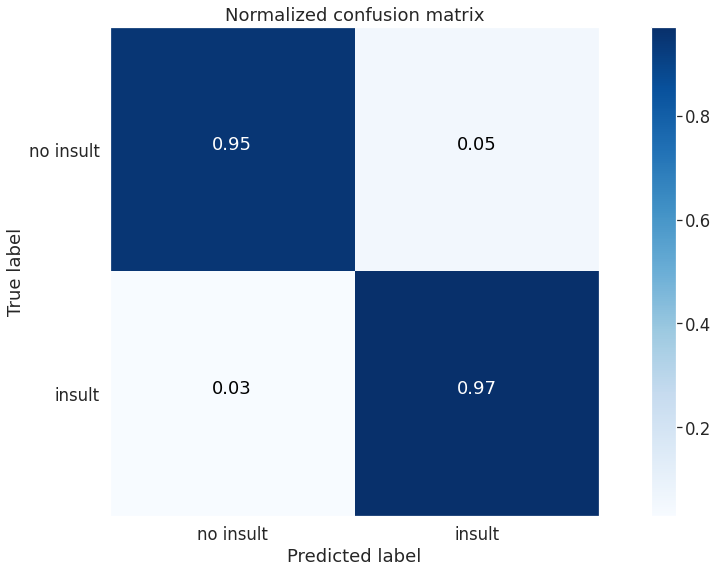

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



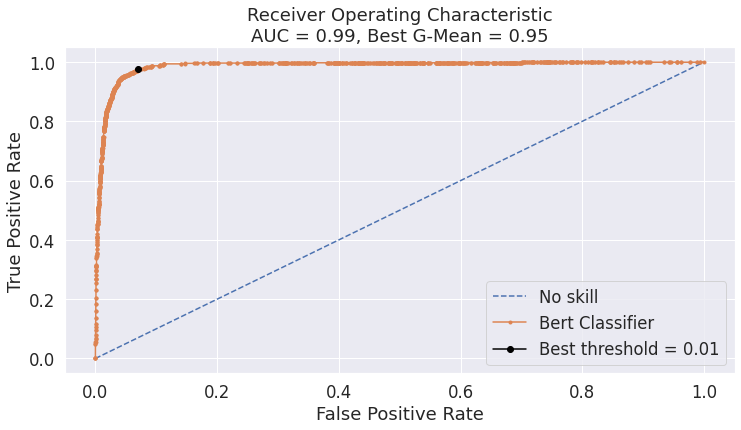

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.01



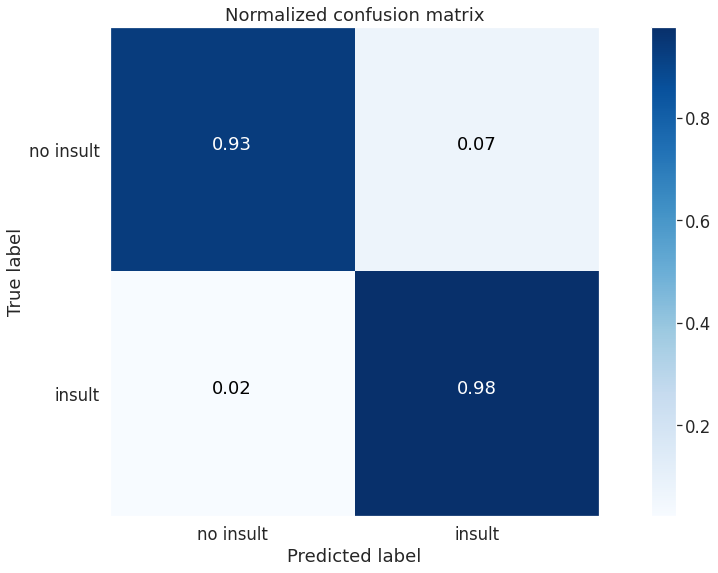

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

#### Identity hate

In [ ]:
idx = 5
cat = categories[idx]
y_true = datasets['test'][cat]
bert_cat_probs = bert_probs[:, idx]
distilbert_cat_probs = distilbert_probs[:, idx]

--------
| BERT |
-------- 



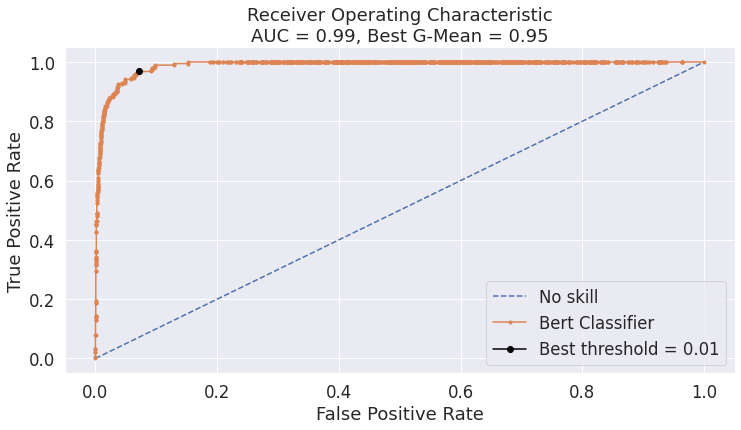

In [ ]:
print_model_name(bert)
thresholds['bert'][cat] = evaluate_roc(bert_cat_probs, y_true)

--------
| BERT |
-------- 

threshold = 0.01



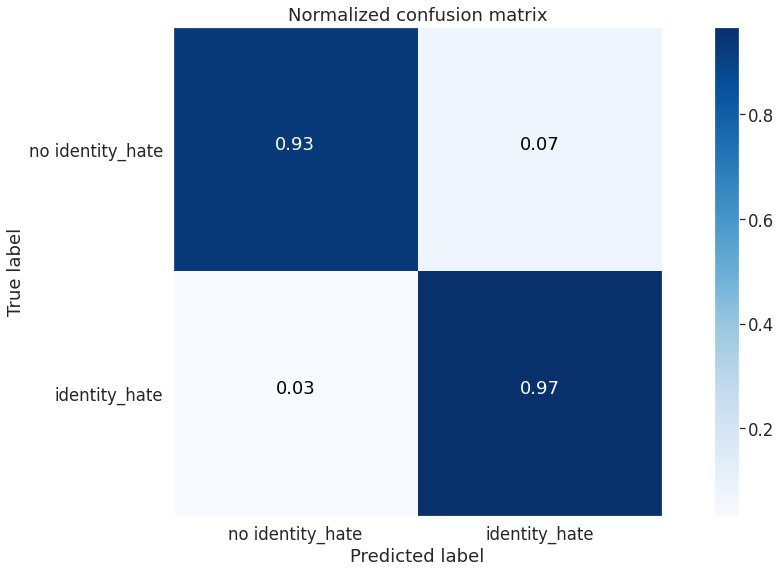

In [ ]:
bert_preds_thres = np.where(bert_probs[:, idx] >= thresholds['bert'][cat], 1, 0)
bert_conf_thres = confusion_matrix(y_true, bert_preds_thres)
print_model_name(bert)
print('threshold = {:.2f}\n'.format(thresholds['bert'][cat]))
plot_confusion_matrix(bert_conf_thres, ('no ' + cat, cat))

--------------
| DistilBERT |
-------------- 



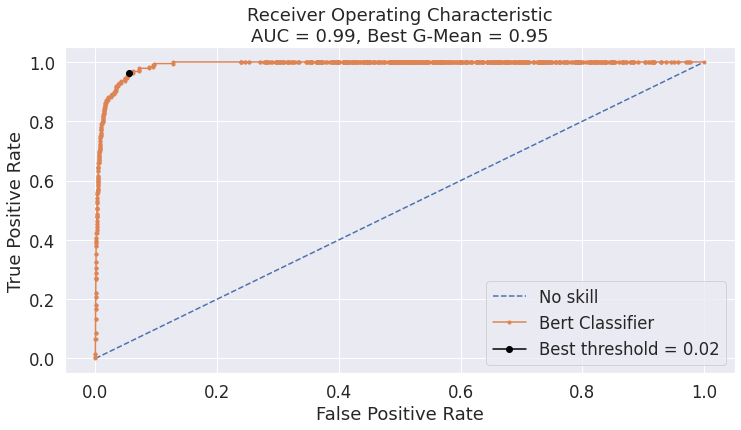

In [ ]:
print_model_name(distilbert)
thresholds['distilbert'][cat] = evaluate_roc(distilbert_cat_probs, y_true)

--------------
| DistilBERT |
-------------- 

threshold = 0.02



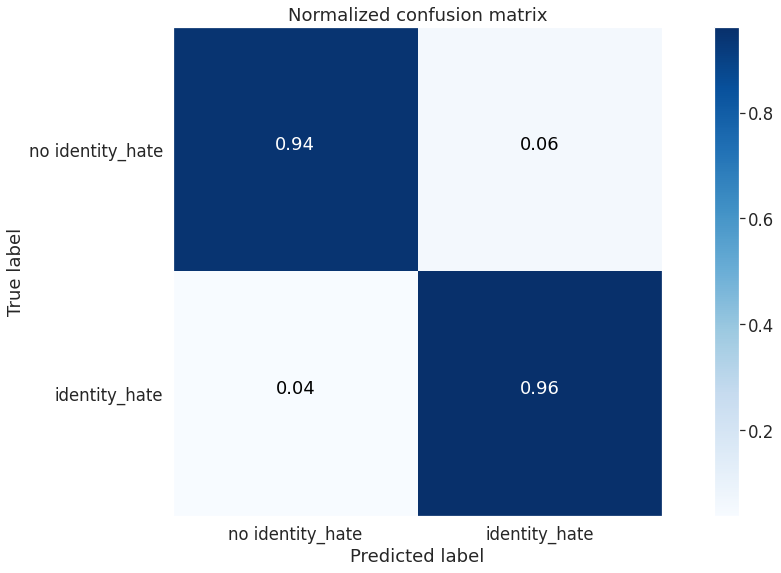

In [ ]:
distilbert_preds_thres = np.where(distilbert_probs[:, idx] >= thresholds['distilbert'][cat], 1, 0)
distilbert_conf_thres = confusion_matrix(datasets['test'][cat], distilbert_preds_thres)
print_model_name(distilbert)
print('threshold = {:.2f}\n'.format(thresholds['distilbert'][cat]))
plot_confusion_matrix(distilbert_conf_thres, ('no ' + cat, cat))

As it can be seen, the results are similar in the 6 categories, in spite of the significant differences in the amount of samples. Both models perform very well predicting each of the classes, with a minor number of missclassifications. As it can be seen in next cells, the optimal thresholds are really close to 0. This may be due to the fact that it is better to have a false positive instead of a false negative, in terms of maximizing the AUC (Area Under the Curve), for these data.

In [ ]:
print_model_name(bert)
thresholds['bert']

--------
| BERT |
-------- 



{'identity_hate': 0.011171914,
 'insult': 0.01827044,
 'obscene': 0.028351337,
 'severe_toxic': 0.012142692,
 'threat': 0.009285363,
 'toxic': 0.0037308002}

In [ ]:
print_model_name(distilbert)
thresholds['distilbert']

--------------
| DistilBERT |
-------------- 



{'identity_hate': 0.016469102,
 'insult': 0.007833247,
 'obscene': 0.040182736,
 'severe_toxic': 0.015630798,
 'threat': 0.012213027,
 'toxic': 0.013721815}

Finally both models are evaluated again but employing the found thresholds to make the predictions.

In [ ]:
bert_probs, bert_preds, bert_test_stats = bert_trainer.evaluate(
    thresholds = torch.tensor(list(thresholds['bert'].values())),
    test=True)


Using GPU Tesla P100-PCIE-16GB 

--------
| BERT |
-------- 

Evaluation: 489 batches

 Hamming   |  Eval Loss   |  Elapsed 
-------------------------------------
 0.891633  |   0.054059   |  0:01:02 
-------------------------------------




In [ ]:
distilbert_probs, distilbert_preds, distilbert_test_stats = distilbert_trainer.evaluate(
    thresholds = torch.tensor(list(thresholds['distilbert'].values())),
    test=True)


Using GPU Tesla P100-PCIE-16GB 

--------------
| DistilBERT |
-------------- 

Evaluation: 489 batches

 Hamming   |  Eval Loss   |  Elapsed 
-------------------------------------
 0.893641  |   0.052840   |  0:00:32 
-------------------------------------




As it can be seen, the hamming score decreases in both cases. Consequently, it can be said that these thresholds improve the individual accuracy, but the general result gets worse, so it should be considered which is the main requirement in the implementation. Mention that the evaluation losses remain unchanged because they do not depend on the raw predictions.

Finally, the new predictions are displayed for a test sample as before.

In [ ]:
sample = datasets['test'][(datasets['test'][categories[0]]==1) | 
                          (datasets['test'][categories[1]]==1) |
                          (datasets['test'][categories[2]]==1) |
                          (datasets['test'][categories[3]]==1) |
                          (datasets['test'][categories[4]]==1) |
                          (datasets['test'][categories[5]]==1)].sample()
idx = sample.index[0]
print(sample.text.values[0], '\n')
df = pd.DataFrame(index=categories)
df['labels'] = sample.labels.values[0]
df['BERT preds'] = bert_preds[idx, :]
df['BERT probs'] = bert_probs[idx]
df['DistilBERT preds'] = distilbert_preds[idx, :]
df['DistilBERT probs'] = distilbert_probs[idx]
df

what ever you fuggin fag Question how did you know they were not mine 



,labels,BERT preds,BERT probs,DistilBERT preds,DistilBERT probs
toxic,1,1,0.988894,1,0.970364
severe_toxic,0,1,0.108070,1,0.017334
obscene,0,1,0.971331,1,0.942904
threat,0,0,0.003226,0,0.003709
insult,0,1,0.935586,1,0.417044
identity_hate,0,1,0.155988,1,0.031972


It can be seen how both models produce some false positives, due to the new thresholds, as with *severe_toxic* and *identity_hate*. Also mention that multilabel classification is more complex than multiclass, and more errors are expected, especially with categories with few samples.

# Cite

Thanks for reading! If you find it useful, feel free to use it. You can cite it as:

```
@mastersthesis{bueno2022distilbert,
  author    = {Bueno, Ion},
  title     = {DistilBERT, the alternative to massive models for natural language processing},
  school    = {University Carlos III of Madrid},
  year      = {2022},
  month     = {jun},
  address   = {Madrid, Spain},
  url       = {https://github.com/ion-bueno/distilbert-from-inside}
}
```